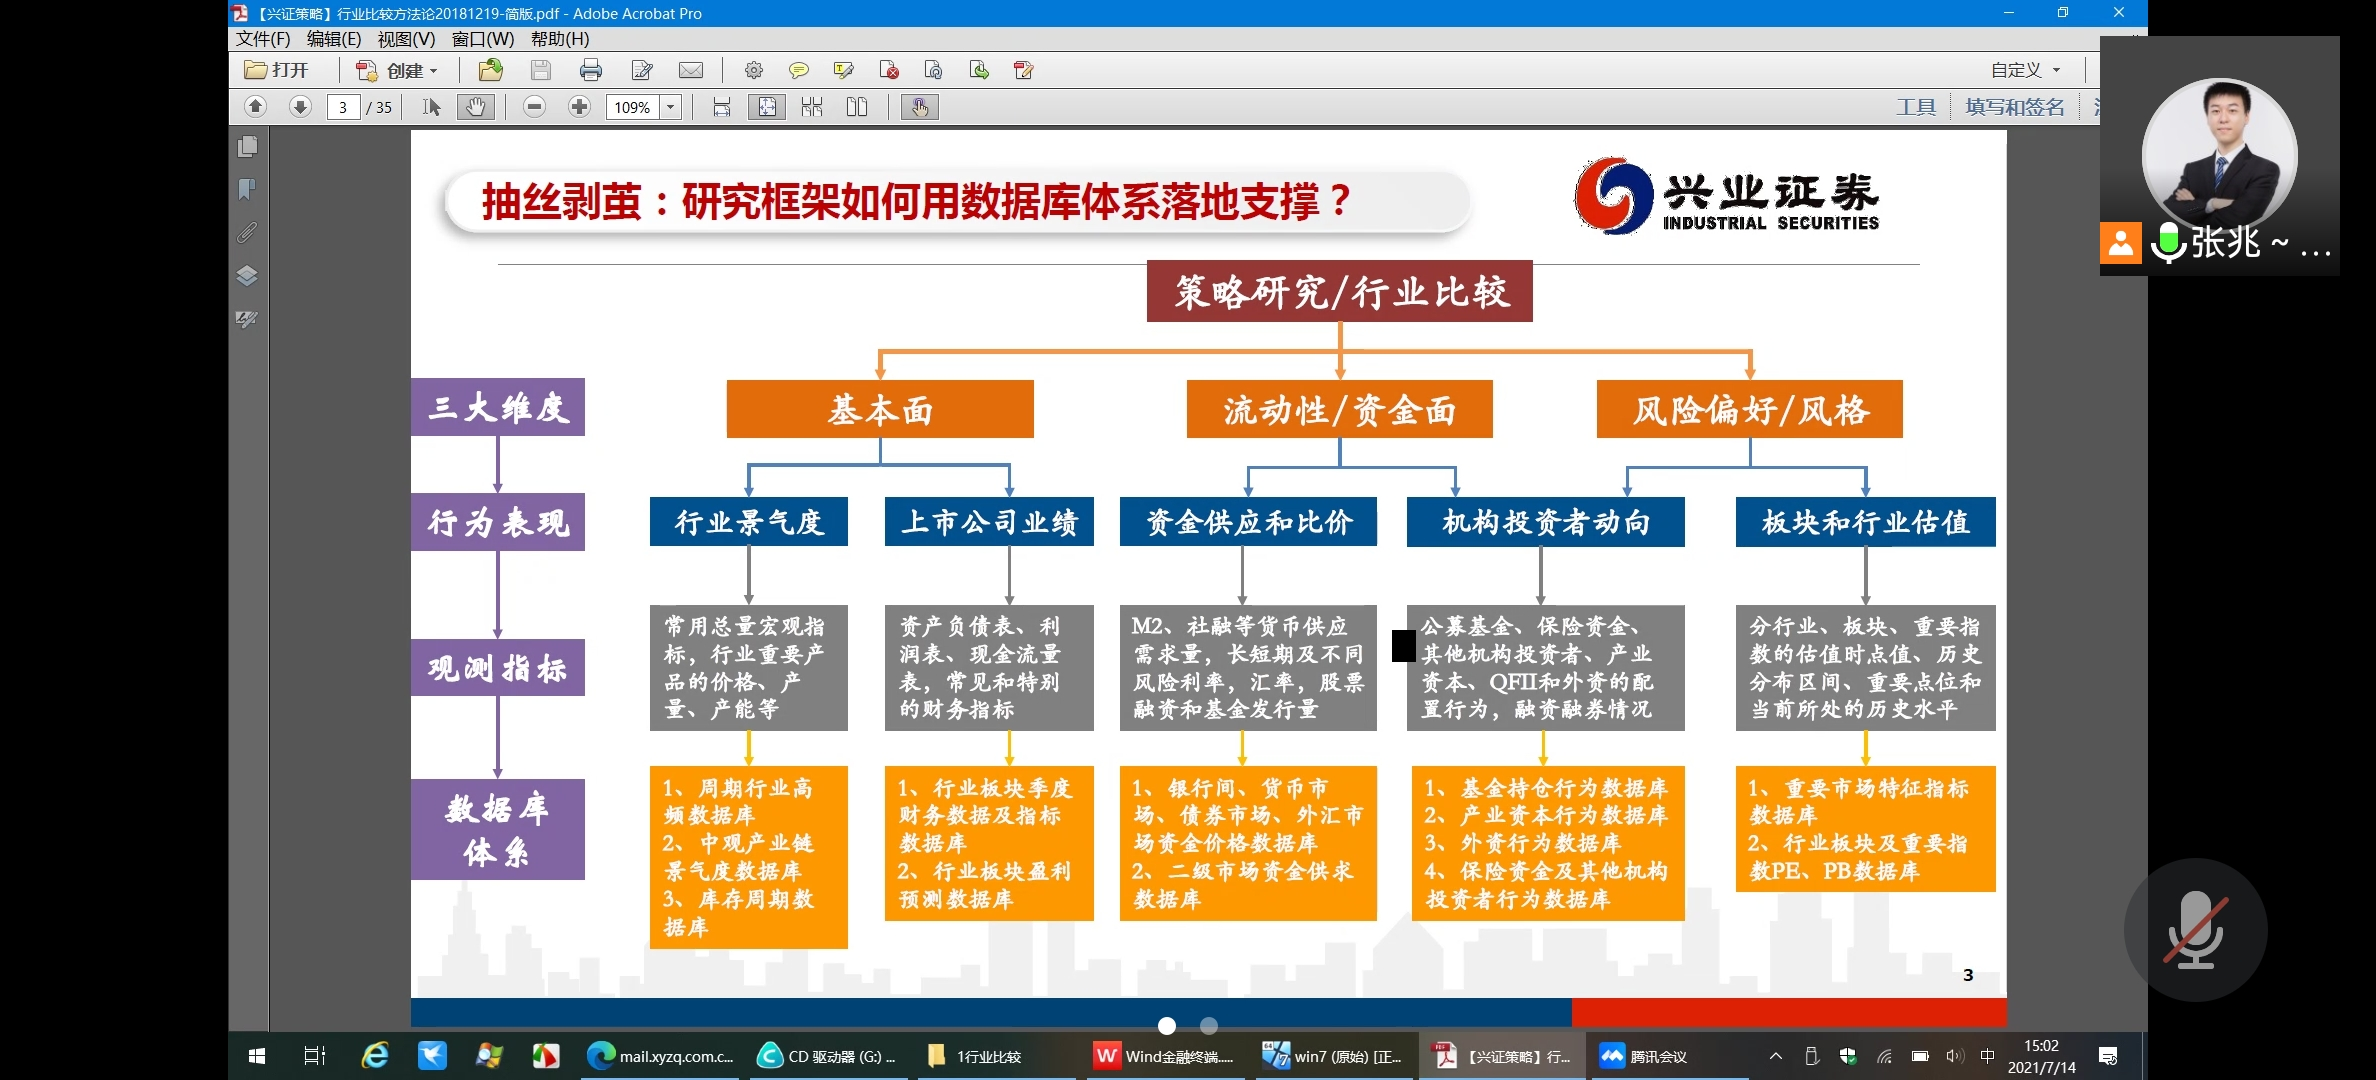

两个任务：择股、择时 
三个维度：基本面、流动性/资金面、风险偏好/风格

择股看基本面
投资驱动的行业：半导体 通信  要挖掘链条
戴维斯双击 量价齐升 估值盈利都拉升
要找到价升量还没来得及升的地方
基本面需要得出的结论：哪些行业景气，大概景气多久，仅仅提供一个参考，因为基本面好不一定会立刻涨，还要看市场流动性和风险偏好。

择时：什么时候投呢，看流动性和风险偏好。
流动性分量价，资金抄什么。能不能涨取决于流动性好不好，资金往哪边涌，资金量价是否有利于资金炒作。
风险偏好估值只能作为参考。

# 导入模块

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import matplotlib.transforms as transforms

from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, Image
from reportlab.platypus.tableofcontents import TableOfContents
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.styles import ParagraphStyle as PS
from reportlab.platypus import PageBreak
from reportlab.platypus.paragraph import Paragraph
from reportlab.platypus.doctemplate import PageTemplate, BaseDocTemplate
from reportlab.platypus.frames import Frame
from reportlab.lib.units import cm

from WindPy import *
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 全局参数

In [2]:
# 日报/周报/月报/季报/半年报/年报
report_class = 'daily'

# 日期
today = date.today()
yesterday = today - timedelta(days=1)
begin_date = '2010-01-03'
rpt_date = '2020-12-31'
trade_day = w.tdays((today-timedelta(days=30)).strftime('%Y%m%d'), today.strftime('%Y%m%d'), '', usedf=True)
last_update_day = '2021-07-28'
last_trade_day = trade_day[1].iloc[-1][0]
last2_trade_day = trade_day[1].iloc[-2][0]
last5_trade_day = trade_day[1].iloc[-5][0] # 过去一周
last22_trade_day = trade_day[1].iloc[-22][0] # 过去1个月

# 画图
## 高低估区间
estimate_interval = [0.3,0.7]

barcolor = ['#004c94', '#f05f5f', '#65a2e5', '#ffbdc8', '#bfbfbf', '#ffc000', '#e02622']
linecolor = ['#e02622', '#08287f', '#bfbfbf', '#ff9933', '#5acdf5', '#f05f5f', '#737373']
barlinecolor = ['#e02622', '#bfbfbf', '#5acdf5', '#ff9933', '#ffbdc8', '#f05f5f', '#08287f']

params = {'axes.titlesize' : 36,
          'legend.fontsize' : 20,
          'figure.figsize' : (16,10),
          'axes.labelsize' : 20,
          'xtick.labelsize' : 20,
          'ytick.labelsize' : 20,
          "font.family":'serif',
          "mathtext.fontset":'stix',
          "font.serif": ['SimSun'],
          'figure.titlesize' : 36,
         'axes.unicode_minus': False}
plt.rcParams.update(params)

figwidth = 16 * 28
figheight = 10 * 28

# 表格显示
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20

In [3]:
# 定义模板
class MyDocTemplate(BaseDocTemplate):
    def __init__(self, filename, **kw):
        self.allowSplitting = 0
        BaseDocTemplate.__init__(self, filename, **kw)
        template = PageTemplate('normal', [Frame(2.5*cm, 2.5*cm, 15*cm, 25*cm, id='F1')])
        self.addPageTemplates(template)
    
    def afterFlowable(self, flowable):
        "Registers TOC entries."
        if flowable.__class__.__name__ == 'Paragraph':
            text = flowable.getPlainText()
            style = flowable.style.name
            if style == 'title1':
                level = 0
            elif style == 'title2':
                level = 1
            elif style == 'title3':
                level = 2
            elif style == 'title4':
                level = 3
            else:
                return
            E = [level, text, self.page]
            #if we have a bookmark name append that to our notify data
            bn = getattr(flowable,'_bookmarkName',None)
            if bn is not None:
                E.append(bn)
            self.notify('TOCEntry', tuple(E))  

# 注册字体
pdfmetrics.registerFont(TTFont('hwzs', 'STZHONGS.ttf'))

# 表格格式，三线表
ts = [('ALIGN',(0,0),(-1,-1),'CENTER'),
    ('VALIGN',(0,0),(-1,-1),'MIDDLE'),
    ('FONT', (0,0), (-1,-1), 'hwzs'),
    ('LINEABOVE', (0,0), (-1,0), 1, colors.black),
    ('LINEBELOW', (0,-1), (-1,-1), 1, colors.black),
    ('LINEBELOW', (0,0), (-1,0), 1, colors.black)]
        
# 定义样式
stylesheet = getSampleStyleSheet()
stylesheet.add(
    ParagraphStyle(name='body',
                   fontName="hwzs",
                   fontSize=10,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=20,        # 首行缩进，每个汉字为10
                   alignment=TA_JUSTIFY,      # 对齐方式
                   ))
stylesheet.add(
    ParagraphStyle(name='title0',
                   fontName="hwzs",
                   fontSize=20,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=0,        # 首行缩进，每个汉字为10
                   alignment=1    # 对齐方式
                   ))
stylesheet.add(
    ParagraphStyle(name='title1',
                   fontName="hwzs",
                   fontSize=18,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=0,        # 首行缩进，每个汉字为10
                   alignment=TA_JUSTIFY    # 对齐方式
                   ))
stylesheet.add(
                ParagraphStyle(name='title2',
                   fontName="hwzs",
                   fontSize=16,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=0,        # 首行缩进，每个汉字为10
                   alignment=TA_JUSTIFY   # 对齐方式
                   ))
stylesheet.add(
            ParagraphStyle(name='title3',
                   fontName="hwzs",
                   fontSize=14,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=0,        # 首行缩进，每个汉字为10
                   alignment=TA_JUSTIFY    # 对齐方式
                   ))
stylesheet.add(
            ParagraphStyle(name='title4',
                   fontName="hwzs",
                   fontSize=12,
                   textColor='black',
                   leading=15,                # 行间距
                   spaceBefore=15,             # 段前间距
                   spaceAfter=15,             # 段后间距
                   leftIndent=0,              # 左缩进
                   rightIndent=0,             # 右缩进
                   firstLineIndent=0,        # 首行缩进，每个汉字为10
                   alignment=TA_JUSTIFY    # 对齐方式
                   ))

h0 = stylesheet['title0']
h1 = stylesheet['title1']
h2 = stylesheet['title2']
h3 = stylesheet['title3']
h4 = stylesheet['title4']
body = stylesheet['body'] # 正文

# 添加超链接
def doheading(text,sty):
    from hashlib import sha1
    #create bookmarkname
    bn=sha1((text+sty.name).encode('utf-8')).hexdigest()
    #modify paragraph text to include an anchor point with name bn
    h=Paragraph(text+'<a name="%s"/>' % bn,sty)
    #store the bookmark name on the flowable so afterFlowable can see this
    h._bookmarkName=bn
    story.append(h)

In [4]:
# 初始化内容
story = []

# 大标题：时间+复盘报告
text = "{}复盘报告".format(today.strftime('%Y%m%d'))
story.append(Paragraph(text, h0))

# 目录
toc = TableOfContents()
toc.levelStyles = [
    PS(fontName='hwzs', fontSize=18, name='TOCHeading1', leftIndent=20, firstLineIndent=-20, spaceBefore=10, leading=16),
    PS(fontName='hwzs',fontSize=16, name='TOCHeading2', leftIndent=40, firstLineIndent=-20, spaceBefore=5, leading=12),
    PS(fontName='hwzs',fontSize=14, name='TOCHeading3', leftIndent=60, firstLineIndent=-20, spaceBefore=5, leading=12), 
    PS(fontName='hwzs',fontSize=12, name='TOCHeading4', leftIndent=80, firstLineIndent=-20, spaceBefore=5, leading=12), 
]
story.append(toc)
story.append(PageBreak())



# 将内容输出到PDF中
doc = MyDocTemplate("【{}】每日复盘.pdf".format(today.strftime('%Y%m%d')))

# 全局函数

In [5]:
def cal_current_quantile(df):
    def tempfunc(df):
        df = pd.DataFrame(df)
        value = df.iloc[-1,0]
        total = df.count()
        small = df[df<value].count()
        quantile = (small+1)/total
        return quantile[0]
    df = df.apply(lambda x:tempfunc(x),axis=0)
    return df

def cal_his_quantile(df):
    '''
    计算资产的每天的历史分位数。columns是资产，rows是日期
    '''
    df = pd.DataFrame(df)
    quantile_list = []
    for date in df.index:
        value = df.loc[date][0]
        hisdf = df.loc[df.index <= date]
        totaldays = len(hisdf)
        smallerdays = hisdf[hisdf<value].count()[0]
        quantile = (smallerdays + 1)/totaldays
        quantile_list.append(quantile)
    quantiledf = pd.DataFrame(quantile_list,index=df.index,columns=df.columns)
    return quantiledf

def plot_quantile_cycle(ax,df,label,estimate_interval):
    df.dropna(inplace=True)
    quantile = cal_his_quantile(df)
    ax.plot(df,'deepskyblue',alpha=1,linewidth=2,label=label)
    trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
    for i in range(len(df.index)-1):
        rectrange = [df.index[i],df.index[i+1]]
        if quantile.iloc[i,0] >= estimate_interval[1]:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='r') 
        elif quantile.iloc[i,0] <= estimate_interval[0]:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='g')
        else:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='gold')
    ax.legend()
    return quantile

def plot_close_pe(code,begin_date,end_date,estimate_interval):
    fig,ax = plt.subplots()
    _,close = w.wsd(code, "close", begin_date, end_date, "Fill=Previous", usedf=True)
    _,pe = w.wsd(code, "pe_ttm", begin_date, end_date, "Fill=Previous", usedf=True)
    pe.dropna(inplace=True)
    quantile = cal_his_quantile(pe)
    ax.plot(pe,'deepskyblue',alpha=1,linewidth=2,label='pe')
    ax2 = ax.twinx()
    ax2.plot(close,'orange',alpha=1,linewidth=2,label='close')
    trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
    for i in range(len(pe.index)-1):
        rectrange = [pe.index[i],pe.index[i+1]]
        if quantile.iloc[i,0] >= estimate_interval[1]:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='r') 
        elif quantile.iloc[i,0] <= estimate_interval[0]:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='g')
        else:
            ax.fill_between(rectrange,0,1,linewidth=0,transform=trans,alpha=0.15,color='gold')
    plt.title('{}_PE_his_quantile'.format(code))
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1+handles2, labels1+labels2, loc='upper right')
    plt.xticks()
    plt.yticks()
    plt.show()

def pdf_text(text, style=body):
    story.append(Paragraph(text, body))
    
def df_to_table(df):
    df = df.reset_index()
    df = df.round(2)
    temp = [df.columns[:,].values.astype(str).tolist()] + df.values.tolist()
    return Table(temp, style=ts)

# 大势研判

In [6]:
doheading('大势研判', h1)

# 行业比较

In [7]:
doheading('行业比较', h1)

## 基本面

In [8]:
doheading('基本面', h2)

### 行业景气度

In [9]:
doheading('行业景气度', h3)

In [10]:
doheading('银行', h4)

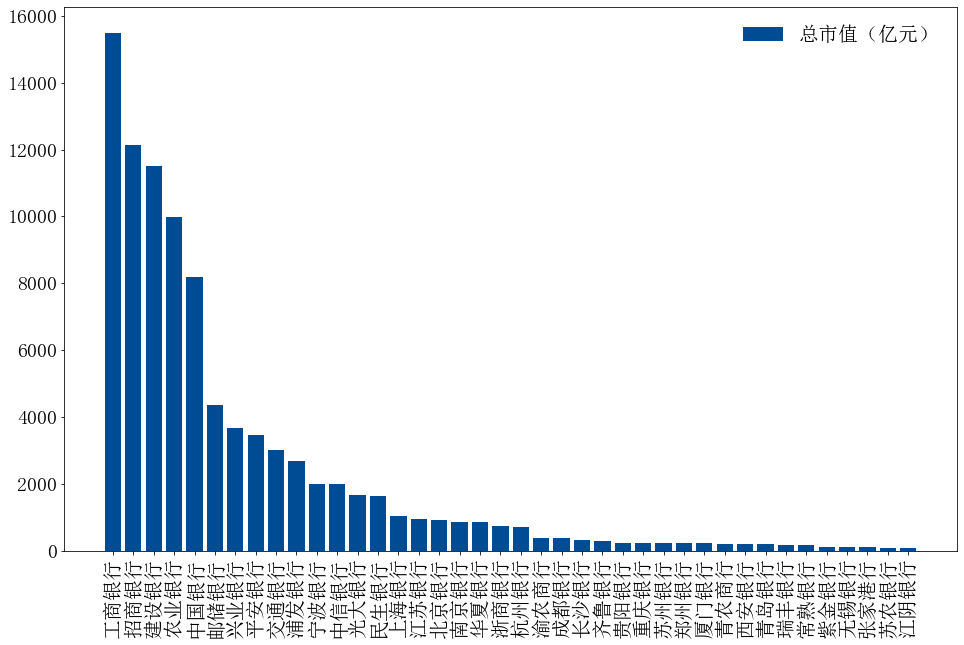

银行业（中信）成分股的基本信息如下所示，总市值、估值数据截至2021-08-03 00:00:00，报告期为2020-12-31。


In [11]:
# 基本信息
_,tempdf = w.wset("sectorconstituent","date={};sectorid=b10l000000000000".format(last_trade_day), usedf=True) # 获得中信银行业成分股
_,tempdf = w.wss(tempdf['wind_code'].tolist(), "sec_name,ipo_date,nature1,industry_citic,ev", 
                 "tradeDate={};industryType=3".format(last_trade_day), usedf=True)
tempdf.columns = ['名称','上市日期','公司性质','中信3级分类','总市值（亿元）']
tempdf = tempdf.sort_values(by='总市值（亿元）',ascending=False)
tempdf['总市值（亿元）'] /= 100000000
## 加入估值数据
_,tempdf2 = w.wss(tempdf.index.tolist(), "pb_lf,roe_avg,west_avgroe_fy1,west_avgroe_fy2,west_avgroe_fy3", 
                  "tradeDate={};rptDate={}".format(last_trade_day,rpt_date), usedf=True)
tempdf2.columns = ['PBlf','ROE（平均）','1年一致预期ROE','2年一致预期ROE','3年一致预期ROE']
tempdf = pd.concat([tempdf, tempdf2], axis=1)
del tempdf2

# 画图
fig,ax = plt.subplots()
ax.bar(tempdf['名称'], tempdf['总市值（亿元）'], label='总市值（亿元）', color=barcolor[0])
xticks=list(range(0,len(tempdf['名称']),1)) 
xlabels=[tempdf['名称'][x] for x in xticks] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=90)
ax.legend(framealpha=0)
plt.show()
fig.savefig('20210729_1.png', dpi=400, bbox_inches='tight')

# 写入pdf
text = '银行业（中信）成分股的基本信息如下所示，总市值、估值数据截至{}，报告期为{}。'.format(last_trade_day, rpt_date)
print(text)
pdf_text(text)

tempdf['上市日期'] = [x.strftime('%Y-%m-%d') for x in tempdf['上市日期']]
story.append(df_to_table(tempdf))
img = Image('20210729_1.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

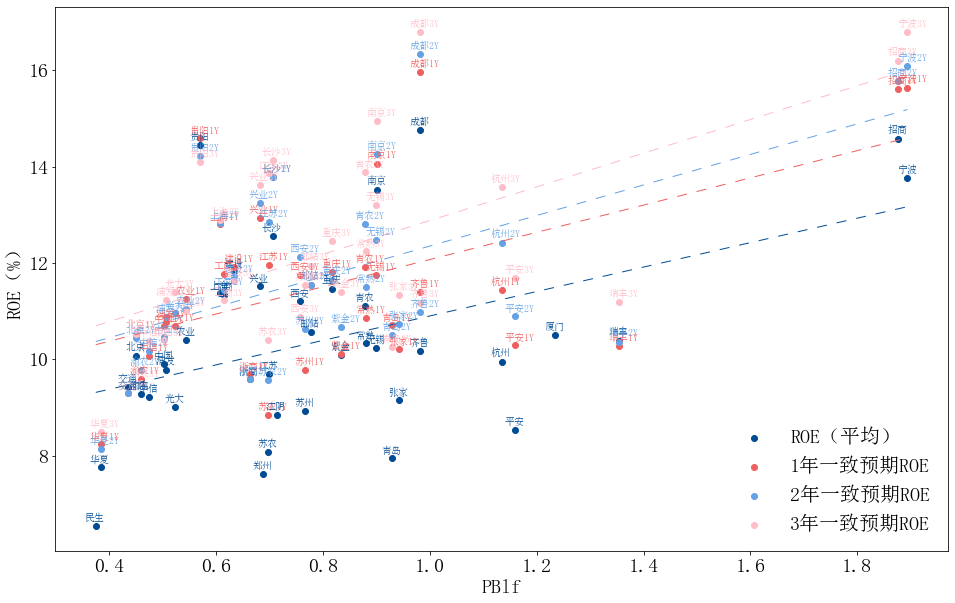

银行的PB-ROE如图所示，估值数据截至2021-07-28，报告期为2020-12-31。


In [12]:
# 画图
def temp_func(ax, x, y, label, color):
    func = np.polyfit(x[~y.isna()], y[~y.isna()], 1)
    y2 = np.polyval(func, x)
    ax.scatter(x, y, label=label, color=color)
    ax.plot([x.min(),x.max()], [y2.min(),y2.max()], ls=(0,(10,10)), lw=1, color=color)
    return None

fig,ax = plt.subplots()
temp_func(ax, tempdf['PBlf'], tempdf['ROE（平均）'], 'ROE（平均）', barcolor[0])
temp_func(ax, tempdf['PBlf'], tempdf['1年一致预期ROE'], '1年一致预期ROE', barcolor[1])
temp_func(ax, tempdf['PBlf'], tempdf['2年一致预期ROE'], '2年一致预期ROE', barcolor[2])
temp_func(ax, tempdf['PBlf'], tempdf['3年一致预期ROE'], '3年一致预期ROE', barcolor[3])
plt.xlabel('PBlf')
plt.ylabel('ROE（%）')
for i in tempdf.index:
    plt.annotate(tempdf.loc[i,'名称'][0:2], xy = (tempdf.loc[i,'PBlf']-0.02, tempdf.loc[i,'ROE（平均）']+0.1), color=barcolor[0])
    plt.annotate(tempdf.loc[i,'名称'][0:2]+'1Y', xy = (tempdf.loc[i,'PBlf']-0.02, tempdf.loc[i,'1年一致预期ROE']+0.1), color=barcolor[1])
    plt.annotate(tempdf.loc[i,'名称'][0:2]+'2Y', xy = (tempdf.loc[i,'PBlf']-0.02, tempdf.loc[i,'2年一致预期ROE']+0.1), color=barcolor[2])
    plt.annotate(tempdf.loc[i,'名称'][0:2]+'3Y', xy = (tempdf.loc[i,'PBlf']-0.02, tempdf.loc[i,'3年一致预期ROE']+0.1), color=barcolor[3])
ax.legend(framealpha=0)
plt.show()
fig.savefig('20210729_2.png', dpi=400, bbox_inches='tight')

# 写入pdf
text = '银行的PB-ROE如图所示，估值数据截至2021-07-28，报告期为2020-12-31。'
print(text)
pdf_text(text)
img = Image('20210729_2.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

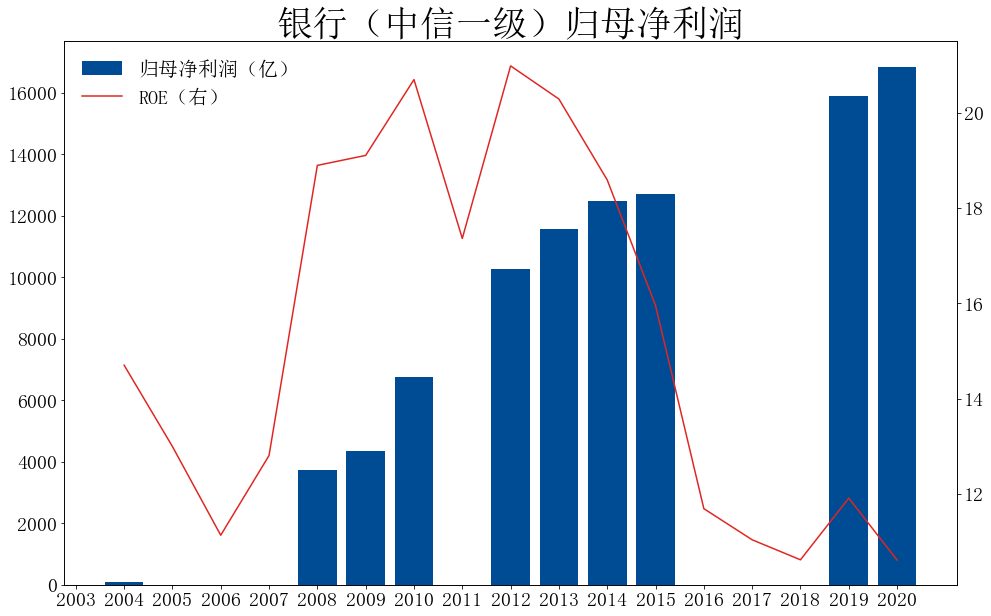

银行ROE和归母净利润如下图所示。最近一年年报显示的银行归母净利润为16839.66亿元，ROE为10.61%


In [13]:
# 行业净利润
_,tempdf = w.wsd("CI005021.WI", "roe_avg,np_belongto_parcomsh", '2000', today.strftime('%Y'), "unit=1;rptType=1;Period=Y",usedf=True)
tempdf.columns = ['ROE', '归母净利润']
tempdf['归母净利润'] = tempdf['归母净利润'] / 100000000
tempdf.columns = ['ROE', '归母净利润（亿）']
tempdf.index = pd.to_datetime(tempdf.index)
tempdf = tempdf.iloc[:-1,:] # 剔除2021年 为空值

# 画图
fig,ax = plt.subplots()
ax.bar(tempdf.index.strftime('%Y'), tempdf['归母净利润（亿）'], label='归母净利润（亿）', color=barcolor[0])
ax2 = ax.twinx()
ax2.plot(tempdf.index.strftime('%Y'), tempdf['ROE'], label='ROE（右）', color=barlinecolor[0])
ax.set_title('银行（中信一级）归母净利润')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1+handles2, labels1+labels2, framealpha=0, loc='upper left')
plt.show()
fig.savefig('20210721_1.png', dpi=400, bbox_inches='tight')

# 写入pdf
text = '银行ROE和归母净利润如下图所示。最近一年年报显示的银行归母净利润为{:.2f}亿元，ROE为{:.2f}%'.format(tempdf.iloc[-1,1],tempdf.iloc[-1,0])
print(text)
pdf_text(text)
img = Image('20210721_1.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

### 上市公司业绩

In [14]:
doheading('上市公司业绩', h3)

## 资金面/流动性

In [15]:
doheading('资金面/流动性', h2)

### 资金供应和比价

In [16]:
doheading('资金供应和比价', h3)

### 机构投资者动向（总量/资金）

In [17]:
doheading('机构投资者动向（总量/资金）', h3)

#### 北向资金

In [18]:
doheading('北向资金', h4)

In [19]:
# 下载全年数据
#_,hgtdf = w.wset("shhktransactionstatistics", "startdate={};enddate={};cycle=Day;currency=HKD".format(str(today.year)+'0101',last_trade_day), usedf=True)
#_,sgtdf = w.wset("szhktransactionstatistics", "startdate={};enddate={};cycle=Day;currency=HKD".format(str(today.year)+'0101',last2_trade_day), usedf=True)

#hgtdf.set_index(['date'], inplace=True)
#sgtdf.set_index(['date'], inplace=True)

#hgtdf.to_excel('【{}】今年以来北向资金沪股通净流入（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')))
#sgtdf.to_excel('【{}】今年以来北向资金深股通净流入（亿元）.xlsx'.format(last2_trade_day.strftime('%Y-%m-%d')))

In [20]:
# 更新数据
try:
    hgtdf = pd.read_excel('【{}】今年以来北向资金沪股通净流入（亿元）.xlsx'.format(last_update_day), index_col=0)
    sgtdf = pd.read_excel('【{}】今年以来北向资金深股通净流入（亿元）.xlsx'.format(last_update_day), index_col=0)

    _,tempdf = w.wset("shhktransactionstatistics", "startdate={};enddate={};cycle=Day;currency=HKD".format(last_update_day,last_trade_day), usedf=True)
    _,tempdf2 = w.wset("szhktransactionstatistics", "startdate={};enddate={};cycle=Day;currency=HKD".format(last_update_day,last_trade_day), usedf=True)
    tempdf.set_index(['date'], inplace=True)
    tempdf2.set_index(['date'], inplace=True)

    hgtdf = tempdf.append(hgtdf)
    hgtdf = hgtdf[~hgtdf.index.duplicated()] # 去除重复项

    sgtdf = tempdf2.append(sgtdf)
    sgtdf = sgtdf[~sgtdf.index.duplicated()] # 去除重复项

    hgtdf.to_excel('【{}】今年以来北向资金沪股通净流入（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')))
    sgtdf.to_excel('【{}】今年以来北向资金深股通净流入（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')))
    os.remove('【{}】今年以来北向资金沪股通净流入（亿元）.xlsx'.format(last_update_day))
    os.remove('【{}】今年以来北向资金深股通净流入（亿元）.xlsx'.format(last_update_day))
    print('已经更新完成')
    
except:
    print('请检查是否已经更新过？')

已经更新完成


In [21]:
# 处理df
hgtdf = pd.read_excel('【{}】今年以来北向资金沪股通净流入（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')), index_col=0)
sgtdf = pd.read_excel('【{}】今年以来北向资金深股通净流入（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')), index_col=0)

northdf = hgtdf['sh_net_purchases'] + sgtdf['sz_net_purchases']
northdf = pd.DataFrame(northdf,columns=['北向资金净流入（亿元）'])
northdf.dropna(inplace=True)
northdf.sort_values(by='date',inplace=True)
northdf['北向资金今年以来累计流入(亿元)'] = northdf['北向资金净流入（亿元）'].cumsum()
text = '近5日北向资金情况：'

# pdf
print(text)
pdf_text(text)

tempdf = northdf.tail(5)
tempdf.index = [x.strftime('%Y-%m-%d') for x in tempdf.index]
story.append(df_to_table(tempdf))

tempdf

近5日北向资金情况：


,北向资金净流入（亿元）,北向资金今年以来累计流入(亿元)
2021-07-28,80.5282,2279.4772
2021-07-29,42.2796,2321.7568
2021-07-30,22.4716,2344.2284
2021-08-02,51.8386,2396.0670
2021-08-03,17.9915,2414.0585


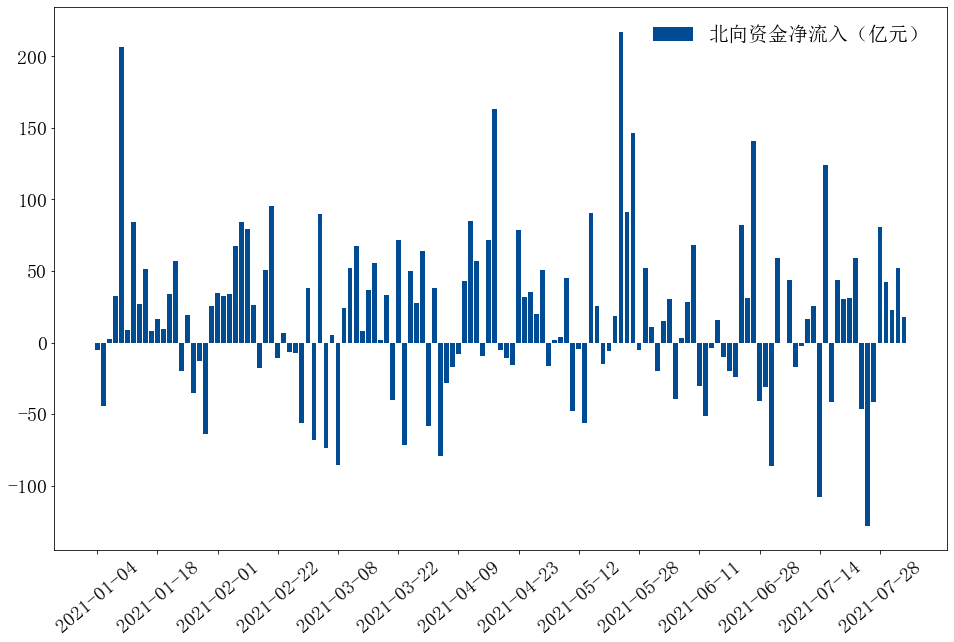

In [22]:
northdf.index = northdf.index.astype(str)

# 画图
fig,ax = plt.subplots()
ax.bar(northdf.index, northdf['北向资金净流入（亿元）'], color=barcolor[0], label='北向资金净流入（亿元）')
xticks=list(range(0,len(northdf.index),10)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[northdf.index[x] for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
#xticks.append(len(northdf.index))
#xlabels.append(northdf.index[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
#ax.set_title('北向资金净流入（亿元）')
ax.legend(framealpha=0)
plt.show()
fig.savefig('temp1.png', dpi=400, bbox_inches='tight')

# pdf
text = '今年以来外资流入情况'
pdf_text(text)
img = Image('temp1.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

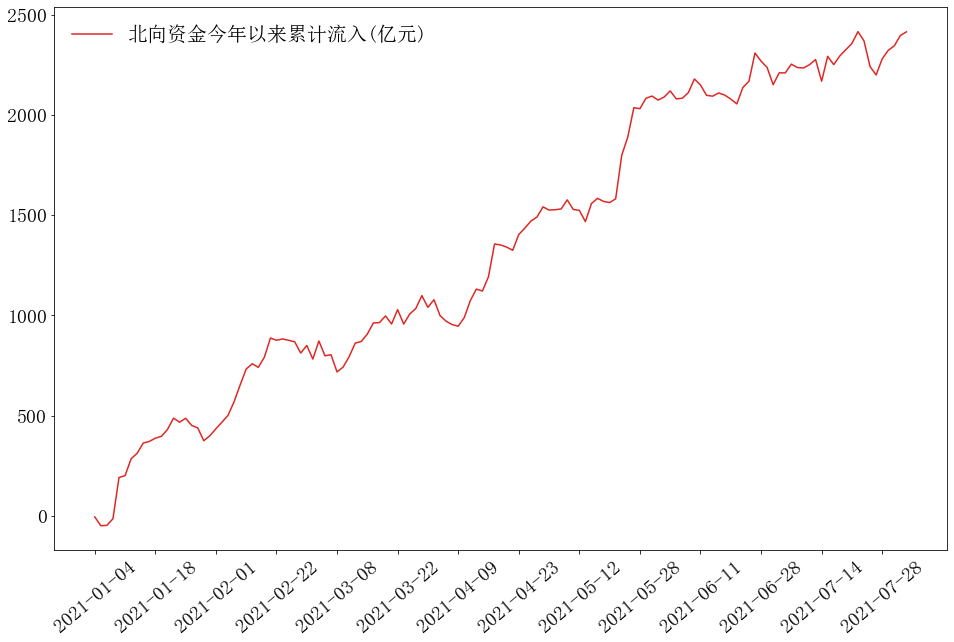

In [23]:
northdf.index = northdf.index.astype(str)

# 画图
fig,ax = plt.subplots()
ax.plot(northdf.index, northdf['北向资金今年以来累计流入(亿元)'], color=linecolor[0], label='北向资金今年以来累计流入(亿元)')
xticks=list(range(0,len(northdf.index),10)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[northdf.index[x] for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
#xticks.append(len(northdf.index))
#xlabels.append(northdf.index[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
#ax.set_title('北向资金今年以来累计流入(亿元)')
ax.legend(framealpha=0)
plt.show()
fig.savefig('temp2.png', dpi=400, bbox_inches='tight')

# pdf
text = '今年以来北向资金累计净流入情况（亿元）'
pdf_text(text)
img = Image('temp2.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

#### 南向资金

In [24]:
doheading('南向资金', h4)

# 处理df
southdf = hgtdf['hk_net_purchases'] + sgtdf['hk_net_purchases']
southdf = pd.DataFrame(southdf)
southdf.columns = ['南向资金净流入（亿元）']
southdf.dropna(inplace=True)
southdf.sort_values(by='date',inplace=True)
southdf['南向资金今年以来累计流入(亿元)'] = southdf['南向资金净流入（亿元）'].cumsum()
southdf.tail(5)

# pdf
text = '近5日南向资金情况：'
print(text)
pdf_text(text)

tempdf = southdf.tail(5)
tempdf.index = [x.strftime('%Y-%m-%d') for x in tempdf.index]
story.append(df_to_table(tempdf))
tempdf

近5日南向资金情况：


,南向资金净流入（亿元）,南向资金今年以来累计流入(亿元)
2021-07-28,-133.4301,4074.4094
2021-07-29,-46.1827,4028.2267
2021-07-30,-15.9506,4012.2761
2021-08-02,-8.6900,4003.5861
2021-08-03,-49.4001,3954.1860


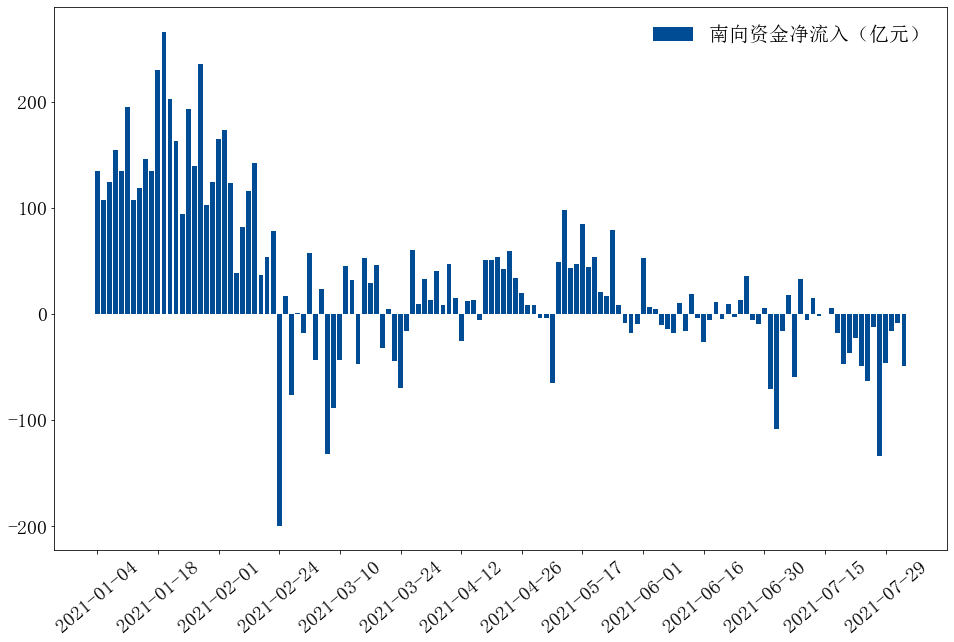

In [25]:
southdf.index = southdf.index.astype(str)

fig,ax = plt.subplots()
ax.bar(southdf.index, southdf['南向资金净流入（亿元）'], color=barcolor[0], label='南向资金净流入（亿元）')
xticks=list(range(0,len(southdf.index),10)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[southdf.index[x] for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
#xticks.append(len(southdf.index))
#xlabels.append(southdf.index[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
#ax.set_title('南向资金净流入（亿元）')
ax.legend(framealpha=0)
plt.show()
fig.savefig('temp3.png', dpi=400, bbox_inches='tight')

text = '今年以来南向资金流入情况：'
pdf_text(text)
img = Image('temp3.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

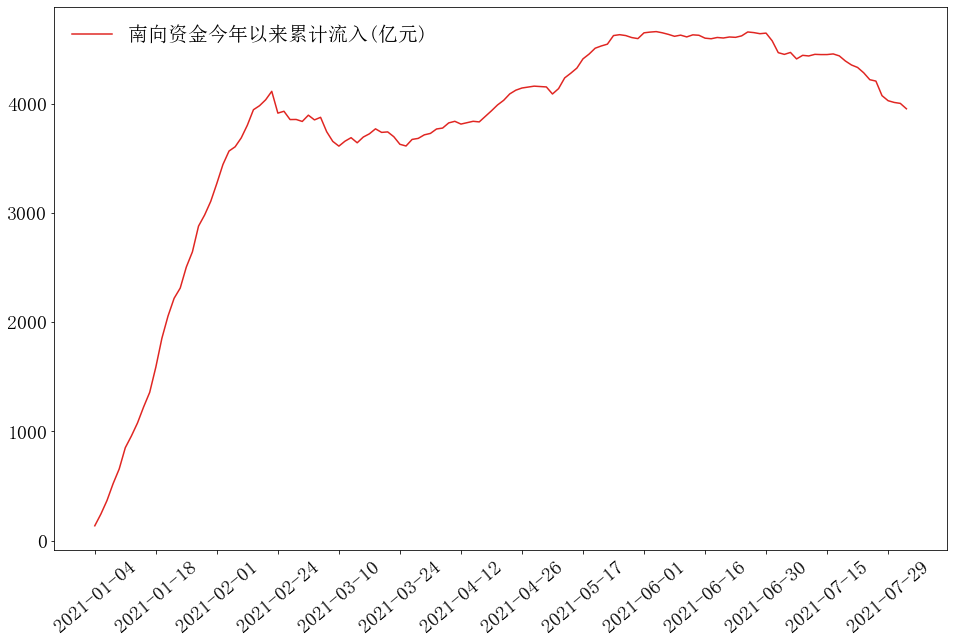

In [26]:
southdf.index = southdf.index.astype(str)
fig,ax = plt.subplots()
ax.plot(southdf.index, southdf['南向资金今年以来累计流入(亿元)'], color=linecolor[0], label='南向资金今年以来累计流入(亿元)')
xticks=list(range(0,len(southdf.index),10)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[southdf.index[x] for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
#xticks.append(len(southdf.index))
#xlabels.append(southdf.index[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=40)
#ax.set_title('南向资金今年以来累计流入(亿元)')
ax.legend(framealpha=0)
plt.show()
fig.savefig('temp4.png', dpi=400, bbox_inches='tight')

text = '今年以来南向资金累计净流入情况（亿元）'
pdf_text(text)
img = Image('temp4.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

## 风险偏好/风格

In [27]:
doheading('风格偏好/风格', h2)

### 成交量与换手率

In [28]:
# pdf标题
doheading('成交量与换手率', h3)

#### 沪深两市与小市值成交额

In [29]:
doheading('沪深两市、小市值指数成交额', h4)

In [30]:
# 沪深两市成交额

## 下载数据
# _,tempdf = w.wsd("000001.SH,399001.SZ", "amt", begin_date, last_update_day, "", usedf=True)
# tempdf = pd.DataFrame(tempdf.sum(axis=1))/100000000
# tempdf.columns = ['沪深两市成交额（亿元）']
# tempdf.index = pd.to_datetime(tempdf.index)
# tempdf.to_excel('【{}】沪深两市成交额（亿元）.xlsx'.format(last_update_day))

## 更新数据
try:
    tempdf = pd.read_excel('【{}】沪深两市成交额（亿元）.xlsx'.format(last_update_day), index_col=0)
    _,tempdf2 = w.wsd("000001.SH,399001.SZ", "amt", last_update_day, last_trade_day, "", usedf=True)
    tempdf2 = pd.DataFrame(tempdf2.sum(axis=1))/100000000
    tempdf2.columns = ['沪深两市成交额（亿元）']
    tempdf2.index = pd.to_datetime(tempdf2.index)
    tempdf = tempdf.append(tempdf2)
    tempdf = tempdf[~tempdf.index.duplicated()] # 去除重复项
    tempdf.to_excel('【{}】沪深两市成交额（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')))
    os.remove('【{}】沪深两市成交额（亿元）.xlsx'.format(last_update_day))
    print('更新已完成')

except:
    print('请检查是否已经更新过了？')

更新已完成


In [31]:
# 小市值指数与其他指数

## 下载数据
_,temp = w.wsd("000016.SH,000300.SH,399006.SZ,399102.SZ,8841425.WI,000688.SH,931643.CSI", "amt", begin_date, last_update_day, "", usedf=True)
temp.index = pd.to_datetime(temp.index)
temp.columns = ['上证50','沪深300','创业板指','创业板综','小市值指数','科创50','双创50']
temp = temp / 100000000
temp.to_excel('【{}】规模指数成交额（亿元）.xlsx'.format(last_update_day))


In [32]:
## 更新数据
try:
    temp = pd.read_excel('【{}】规模指数成交额（亿元）.xlsx'.format(last_update_day), index_col=0)
    _,temp2 = w.wsd("000016.SH,000300.SH,399006.SZ,399102.SZ,8841425.WI,000688.SH,931643.CSI", "amt", last_update_day, last_trade_day, "", usedf=True)
    temp2.index = pd.to_datetime(temp2.index)
    temp2.columns = ['上证50','沪深300','创业板指','创业板综','小市值指数','科创50','双创50']
    temp2 = temp2 / 100000000
    temp = temp.append(temp2)
    temp = temp[~temp.index.duplicated()] # 去除重复项
    temp.to_excel('【{}】规模指数成交额（亿元）.xlsx'.format(last_trade_day.strftime('%Y-%m-%d')))
    os.remove('【{}】规模指数成交额（亿元）.xlsx'.format(last_update_day))
    print('更新已完成')
    
except:
    print('请检查是否已经更新过了？')

更新已完成


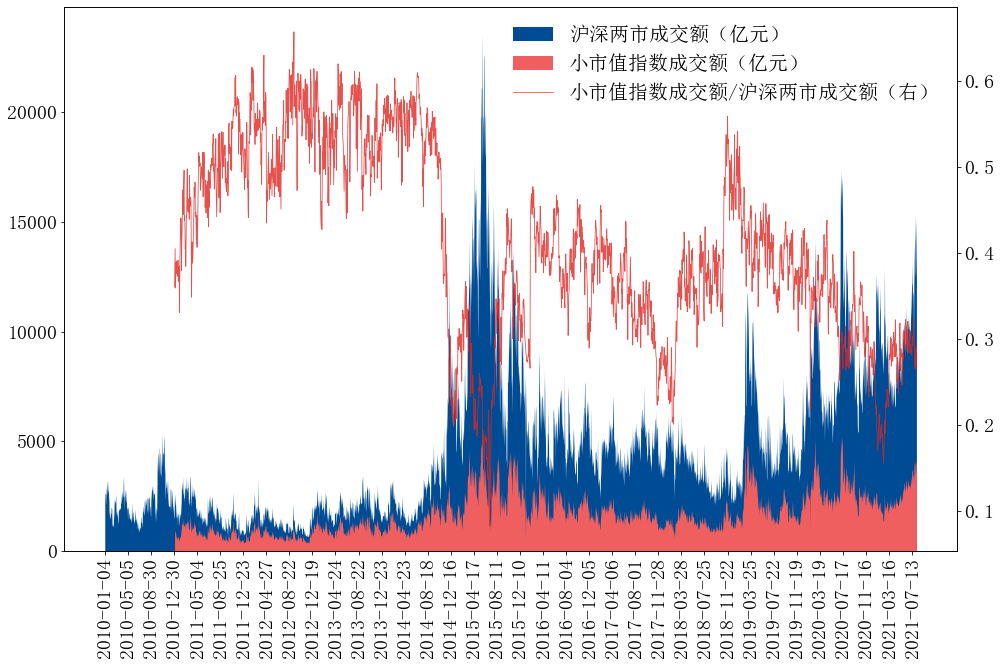

今日小市值板块成交额占沪深两市成交额的比例为29.08%，昨日小市值板块成交额占沪深两市成交额的比例为26.71%，变化2.37%。


In [33]:
# 画图
fig,ax = plt.subplots()
ax.stackplot(tempdf.index.strftime('%Y-%m-%d'), tempdf['沪深两市成交额（亿元）'], linewidth=0,
              color=barcolor[0], labels=['沪深两市成交额（亿元）'])
ax.stackplot(temp.index.strftime('%Y-%m-%d'),temp['小市值指数'], linewidth=0,
              labels=['小市值指数成交额（亿元）'],color=barcolor[1])
ax2 = ax.twinx()
ax2.plot(temp.index.strftime('%Y-%m-%d'),temp['小市值指数']/tempdf['沪深两市成交额（亿元）'], 
         linewidth=0.8, alpha=0.8, label='小市值指数成交额/沪深两市成交额（右）', color=barlinecolor[0])
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

xticks=list(range(0,len(tempdf.index),80)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[tempdf.index[x].strftime('%Y-%m-%d') for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
#xticks.append(len(tempdf.index))
#xlabels.append(tempdf.index[-1])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, rotation=90)
plt.legend(handles1+handles2, labels1+labels2, loc='best', framealpha=0)
plt.show()
fig.savefig('temp20210727_5.png', dpi=400, bbox_inches='tight')

# pdf
text = '今日小市值板块成交额占沪深两市成交额的比例为{:.2f}%，昨日小市值板块成交额占沪深两市成交额的比例为{:.2f}%，变化{:.2f}%。'.format((temp['小市值指数']/tempdf['沪深两市成交额（亿元）'])[-1]*100,
                                                                                       (temp['小市值指数']/tempdf['沪深两市成交额（亿元）'])[-2]*100,
                                                                                       ((temp['小市值指数']/tempdf['沪深两市成交额（亿元）'])[-1] - (temp['小市值指数']/tempdf['沪深两市成交额（亿元）'])[-2])*100)
print(text)
pdf_text(text)

img = Image('temp20210727_5.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

#### 规模指数成交额

In [34]:
tempdf2

,沪深两市成交额（亿元）
2021-07-28,12699.743789
2021-07-29,12494.782753
2021-07-30,13397.131463
2021-08-02,15128.258546
2021-08-03,14161.385252


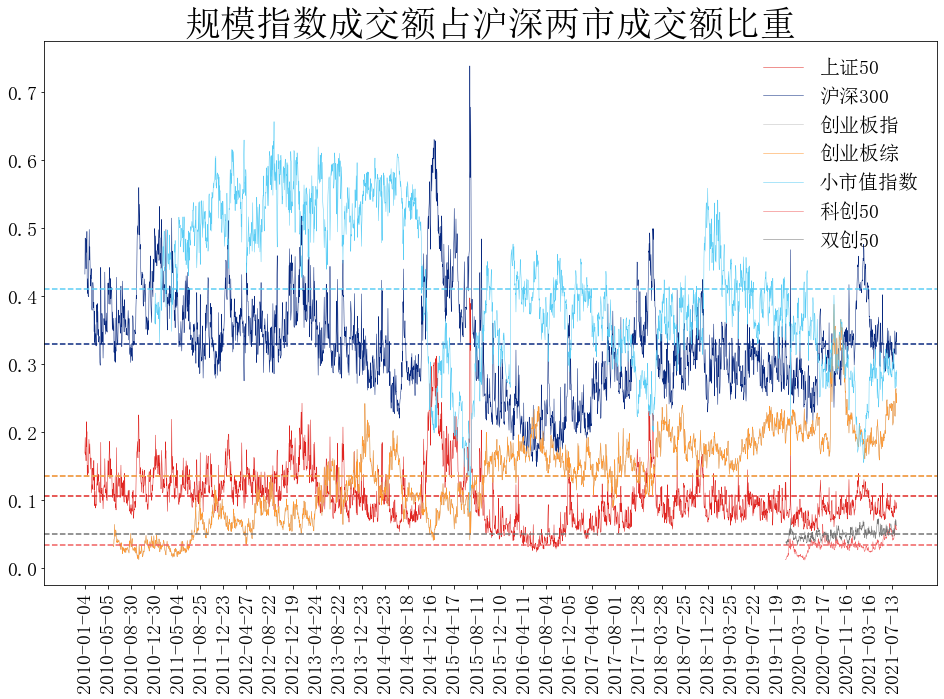

In [35]:
doheading('规模指数成交额', h4)
# 分行业
tempdf2 = temp.div(tempdf['沪深两市成交额（亿元）'].values,axis=0) # 占比
temp = temp.round(2) # 成交额

# # 画图 每个规模画子图
# fig,ax = plt.subplots(len(tempdf2.columns),1, figsize=(16,20))
# xticks=list(range(0,len(tempdf2.index),240)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
# xlabels=[tempdf2.index[x].strftime('%Y-%m-%d') for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
# for i in range(len(tempdf2.columns)):
#     ind = tempdf2.columns[i]
#     ax[i].plot(tempdf2.index.strftime('%Y-%m-%d'), tempdf2[ind], label=ind, color=linecolor[i], linewidth=0.7)
#     ax[i].axhline(tempdf2[ind].mean(), ls='--', color=linecolor[i])
#     ax[i].legend(loc='best', framealpha=0)
#     ax[i].set_xticks(xticks)
#     ax[i].set_xticklabels(xlabels, rotation=0,fontsize=12)
# plt.show()
# fig.savefig('temp20210727_6.png', dpi=400, bbox_inches='tight')

# 画图
fig,ax = plt.subplots()
xticks=list(range(0,len(tempdf2.index),80)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[tempdf2.index[x].strftime('%Y-%m-%d') for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
for i in range(len(tempdf2.columns)):
    ind = tempdf2.columns[i]
    ax.plot(tempdf2.index.strftime('%Y-%m-%d'), tempdf2[ind], label=ind, color=linecolor[i], linewidth=0.5)
    ax.axhline(tempdf2[ind].mean(), ls='--', color=linecolor[i])
    ax.legend(loc='best', framealpha=0)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
plt.title('规模指数成交额占沪深两市成交额比重')
plt.show()
fig.savefig('temp20210727_6.png', dpi=400, bbox_inches='tight')

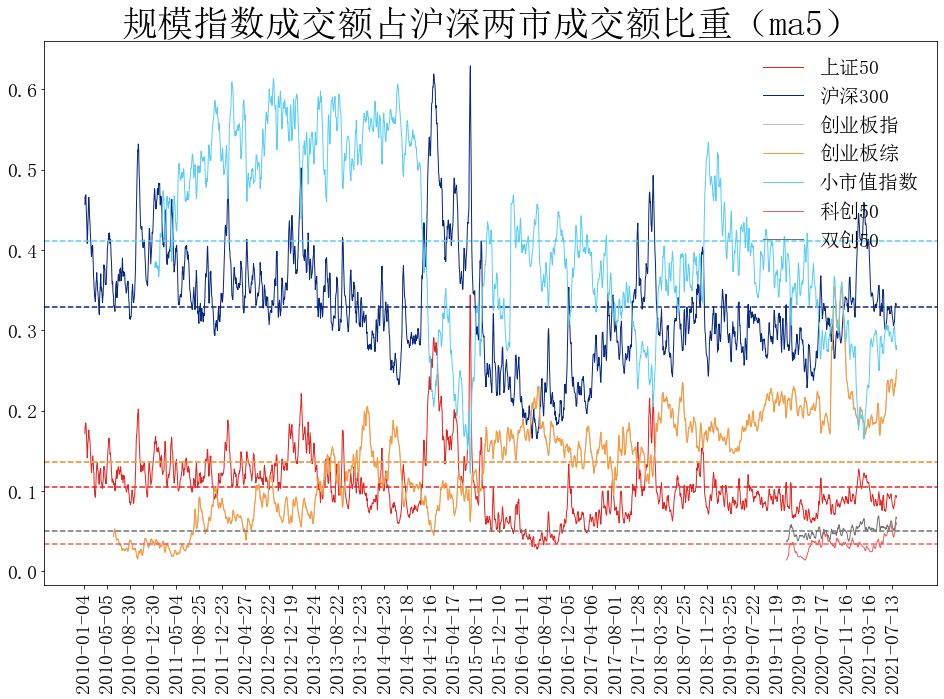

In [36]:
# 分行业 ma5
tempdf2 = temp.div(tempdf['沪深两市成交额（亿元）'].values,axis=0) # 占比
# temp = temp.round(2) # 成交额
tempdf2 = tempdf2.rolling(5).mean()

# # 画图
# fig,ax = plt.subplots(len(tempdf2.columns),1, figsize=(16,20))
# xticks=list(range(0,len(tempdf2.index),240)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
# xlabels=[tempdf2.index[x].strftime('%Y-%m-%d') for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
# for i in range(len(tempdf2.columns)):
#     ind = tempdf2.columns[i]
#     ax[i].plot(tempdf2.index.strftime('%Y-%m-%d'), tempdf2[ind], label=ind, color=linecolor[i], linewidth=0.7)
#     ax[i].axhline(tempdf2[ind].mean(), ls='--', color=linecolor[i])
#     ax[i].legend(loc='best', framealpha=0)
#     ax[i].set_xticks(xticks)
#     ax[i].set_xticklabels(xlabels, rotation=0,fontsize=12)
# plt.show()
# fig.savefig('temp20210727_6.png', dpi=400, bbox_inches='tight')

# 画图
fig,ax = plt.subplots()
xticks=list(range(0,len(tempdf2.index),80)) # 这里设置的是x轴点的位置（40设置的就是间隔了）
xlabels=[tempdf2.index[x].strftime('%Y-%m-%d') for x in xticks] #这里设置X轴上的点对应在数据集中的值（这里用的数据为totalSeed）
for i in range(len(tempdf2.columns)):
    ind = tempdf2.columns[i]
    ax.plot(tempdf2.index.strftime('%Y-%m-%d'), tempdf2[ind], label=ind, color=linecolor[i], linewidth=1)
    ax.axhline(tempdf2[ind].mean(), ls='--', color=linecolor[i])
    ax.legend(loc='best', framealpha=0)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, rotation=90)
plt.title('规模指数成交额占沪深两市成交额比重（ma5）')
plt.show()
fig.savefig('temp20210728_1.png', dpi=400, bbox_inches='tight')

In [37]:
# pdf
text = '''今日其他规模指数成交额占沪深两市的比值为：\n
上证50成交额为{:.2f}亿元,占比{:.2f}%,沪深300成交额为{:.2f}亿元,占比{:.2f}%,创业板指成交额为{:.2f}亿元,占比{:.2f}%,
创业板综成交额为{:.2f}亿元,占比{:.2f}%,小市值指数成交额为{:.2f}亿元,占比{:.2f}%,科创50成交额为{:.2f}亿元,占比{:.2f}%,
双创50成交额为{:.2f}亿元,占比{:.2f}%。\n
注：图中的虚线为成交额占比的均值。'''.format(temp.iloc[-1,0], tempdf2.iloc[-1,0]*100,
                            temp.iloc[-1,1], tempdf2.iloc[-1,1]*100,
                            temp.iloc[-1,2], tempdf2.iloc[-1,2]*100,
                            temp.iloc[-1,3], tempdf2.iloc[-1,3]*100,
                            temp.iloc[-1,4], tempdf2.iloc[-1,4]*100,
                            temp.iloc[-1,5], tempdf2.iloc[-1,5]*100,
                            temp.iloc[-1,6], tempdf2.iloc[-1,6]*100)
print(text)
pdf_text(text)

img = Image('temp20210727_6.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

img = Image('temp20210728_1.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

今日其他规模指数成交额占沪深两市的比值为：

上证50成交额为1254.40亿元,占比9.20%,沪深300成交额为4711.94亿元,占比33.14%,创业板指成交额为3638.04亿元,占比25.11%,
创业板综成交额为3638.04亿元,占比25.11%,小市值指数成交额为4118.31亿元,占比28.11%,科创50成交额为806.47亿元,占比5.88%,
双创50成交额为882.17亿元,占比6.63%。

注：图中的虚线为成交额占比的均值。


#### 行业指数成交额

#### 概念指数成交额

### 机构投资者动向（结构/风格）

In [38]:
doheading('机构投资者动向（结构/风格）', h3)

### 板块和行业估值

In [39]:
doheading('板块和行业估值', h3)

#### 黄金、A股、美股、国债

In [40]:
doheading('大类估值：黄金、A股、美股、国债', h4)

# # 下载数据
# _,gold = w.wsd("GC00.CMX", "close", begin_date, last_update_day, "Fill=Previous", usedf=True)
# _,native_stock = w.wsd("000001.SH", "pe_ttm", begin_date, last_update_day, "Fill=Previous", usedf=True)
# _,nation_stock = w.wsd("DJI.GI", "pe_ttm", begin_date, last_update_day, "Fill=Previous", usedf=True)
# _,bond = w.wsd("TB10Y.WI", "close", begin_date, last_update_day, "Fill=Previous", usedf=True)

# gold.to_excel('【{}】CMX黄金期货连续收盘价.xlsx'.format(last_update_day))
# native_stock.to_excel('【{}】上证指数PE_TTM.xlsx'.format(last_update_day))
# nation_stock.to_excel('【{}】道琼斯指数PE_TTM.xlsx'.format(last_update_day))
# bond.to_excel('【{}】CMX黄金期货连续收盘价.xlsx'.format(last_update_day))

# # 更新数据
# _,gold = w.wsd("GC00.CMX", "close", last_update_day, last_trade_day, "Fill=Previous", usedf=True)
# _,native_stock = w.wsd("000001.SH", "pe_ttm", last_update_day, last_trade_day, "Fill=Previous", usedf=True)
# _,nation_stock = w.wsd("DJI.GI", "pe_ttm", last_update_day, last_trade_day, "Fill=Previous", usedf=True)
# _,bond = w.wsd("TB10Y.WI", "close", last_update_day, last_trade_day, "Fill=Previous", usedf=True)

# # 画图
# text = '时间窗口为{}至{}，黄金价格、上证指数PE_TTM、道琼斯指数PE_TTM、10年期国债收益率倒数的历史分位点走势如下图所示。'.format(begin_date,today)
# pdf_text(text)
# print(text)
# fig,ax = plt.subplots(2,2)
# ax1 = ax[0,0];ax2=ax[0,1];ax3=ax[1,0];ax4=ax[1,1]    
# gold_quantile = plot_quantile_cycle(ax1,gold,'黄金价格',estimate_interval)
# native_stock_quantile = plot_quantile_cycle(ax2,native_stock,'上证指数PE_TTM',estimate_interval)
# nation_stock_quantile = plot_quantile_cycle(ax3,nation_stock,'道琼斯指数PE_TTM',estimate_interval)
# treasure_quantile = plot_quantile_cycle(ax4,1/bond,'10年期国债收益率倒数',estimate_interval) 
# plt.xticks()
# plt.yticks()
# plt.show()
# fig.savefig('temp5.png', dpi=400, bbox_inches='tight')
# img = Image('temp5.png')
# img.drawHeight = figheight
# img.drawWidth = figwidth
# story.append(img)

# text = '时间窗口为{}至{}，黄金的价格处于{:.2f}%分位点，上证指数的滚动市盈率（PE_TTM）处于{:.2f}%分位点，道琼斯指数的滚动市盈率（PE_TTM）处于{:.2f}%分位点，国内10年期国债收益率的倒数处于{:.2f}%分位点。'.format(begin_date,today,gold_quantile.iloc[-1,-1]*100,
#                                                                                                                                         native_stock_quantile.iloc[-1,-1]*100,nation_stock_quantile.iloc[-1,-1]*100,treasure_quantile.iloc[-1,-1]*100)
# pdf_text(text)
# print(text)
# assets = pd.concat([gold,native_stock,nation_stock,1/bond],axis=1)
# assets.columns = ['gold','china_stock','american_stock','bond']
# quantiles = cal_current_quantile(assets)
# fig, ax = plt.subplots()
# ax.bar(quantiles.index,height=quantiles,alpha=0.7)
# ax.set_title('大类资产的高低估水平')
# trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
# plt.fill_between(['gold','bond'],estimate_interval[1],1,linewidth=0,transform=trans,alpha=0.15,color='r')
# plt.fill_between(['gold','bond'],estimate_interval[0],estimate_interval[1],linewidth=0,transform=trans,alpha=0.15,color='gold')
# plt.fill_between(['gold','bond'],0,estimate_interval[0],linewidth=0,transform=trans,alpha=0.15,color='g')
# for a,b in enumerate(quantiles):
#     plt.text(a,b+0.01,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=20)
# plt.show()

# fig.savefig('temp6.png', dpi=400, bbox_inches='tight')
# img = Image('temp6.png')
# img.drawHeight = figheight
# img.drawWidth = figwidth
# story.append(img)

#### 规模指数和中信一级行业指数

In [41]:
doheading('规模指数', h4)

# # 国内规模指数
# _,scaledf = w.wsd("000016.SH,000300.SH,000905.SH,399005.SZ,399006.SZ", "pe_ttm", begin_date, today, "Fill=Previous", usedf=True)
# quantiles = cal_current_quantile(scaledf)
# quantiles.index = ['上证50','沪深300','中证500','中小100','创业板指']

# text = "A股规模指数的估值情况"
# pdf_text(text)
# print(text)
# text = '时间窗口为{}至{}，目前上证50处于{:.2f}%分位点, 沪深300处于{:.2f}%分位点, 中证500处于{:.2f}%分位点, 中小板指处于{:.2f}%分位点, 创业板指处于{:.2f}%分位点'.format(begin_date,today,quantiles[0]*100,quantiles[1]*100,quantiles[2]*100,quantiles[3]*100,quantiles[4]*100)
# pdf_text(text)
# print(text)

# fig, ax = plt.subplots()
# ax.bar(quantiles.index,height=quantiles,alpha=0.7)
# ax.set_title('A股规模指数的高低估水平')
# trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
# plt.fill_between(['上证50','创业板指'],estimate_interval[1],1,linewidth=0,transform=trans,alpha=0.15,color='r')
# plt.fill_between(['上证50','创业板指'],estimate_interval[0],estimate_interval[1],linewidth=0,transform=trans,alpha=0.15,color='gold')
# plt.fill_between(['上证50','创业板指'],0,estimate_interval[0],linewidth=0,transform=trans,alpha=0.15,color='g')
# for a,b in enumerate(quantiles):
#     plt.text(a,b+0.01,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=20)
# plt.show()
# #print('时间窗口为{}至{}，目前上证50处于{:.2f}%分位点, 沪深300处于{:.2f}%分位点, 中证500处于{:.2f}%分位点, 中小板指处于{:.2f}%分位点, 创业板指处于{:.2f}%分位点'\
#  #     .format(begin_date,today,quantiles[0]*100,quantiles[1]*100,quantiles[2]*100,quantiles[3]*100,quantiles[4]*100))
# fig.savefig('temp7.png', dpi=400, bbox_inches='tight')
# img = Image('temp7.png')
# img.drawHeight = figheight
# img.drawWidth = figwidth
# story.append(img)

In [42]:
doheading('行业指数', h4)
# # 国内行业指数
# _,scaledf = w.wsd("CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,"
#                   +"CI005011.WI,CI005012.WI,CI005013.WI,CI005014.WI,CI005015.WI,CI005016.WI,CI005017.WI,CI005018.WI,CI005019.WI,CI005020.WI,"
#                   +"CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI,CI005030.WI,",
#                   "pe_ttm", begin_date, today, "Fill=Previous", usedf=True)
# scaledf.columns = scaledf.columns.str.replace('.WI','')
# scaledf.columns = scaledf.columns.str.replace('CI0050','')
# scaledf.columns = ['石油','煤炭','色金','电公','钢铁','化工','建筑','建材','轻工','机械','新能源','国防','汽车','零售','消服','家电',
#                    '纺织','医药','食饮','农林','银行','非银金','房地产','交通','电子','通信','计算机','传媒','综合','综金']
# quantiles = cal_current_quantile(scaledf)
# fig, ax = plt.subplots()
# ax.bar(quantiles.index,height=quantiles,alpha=0.7)
# ax.set_title('A股中信一级行业指数的高低估水平PE_TTM')
# trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
# plt.fill_between(['石油','综金'],estimate_interval[1],1,linewidth=0,transform=trans,alpha=0.15,color='r')
# plt.fill_between(['石油','综金'],estimate_interval[0],estimate_interval[1],linewidth=0,transform=trans,alpha=0.15,color='gold')
# plt.fill_between(['石油','综金'],0,estimate_interval[0],linewidth=0,transform=trans,alpha=0.15,color='g')
# for a,b in enumerate(quantiles):
#     plt.text(a,b+0.01,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=10)
# #print('时间窗口为{}至{}，中信一级行业PE_TTM历史分位点为：'.format(begin_date,today))
# plt.xticks(rotation=90)
# pe_quantiles = quantiles.copy()
# plt.show()

# text = '时间窗口为{}至{}，中信一级行业PE_TTM历史分位点为：'.format(begin_date,today)
# pdf_text(text)
# print(text)

# fig.savefig('temp8.png', dpi=400, bbox_inches='tight')
# img = Image('temp8.png')
# img.drawHeight = figheight
# img.drawWidth = figwidth
# story.append(img)

In [43]:
# quantiles = cal_current_quantile(scaledf)
# fig, ax = plt.subplots()
# ax.bar(quantiles.index,height=quantiles,alpha=0.7)
# ax.set_title('A股行业高低估水平PB_lf')
# trans=transforms.blended_transform_factory(ax.transData,ax.transAxes)
# plt.fill_between(['石油','综金'],estimate_interval[1],1,linewidth=0,transform=trans,alpha=0.15,color='r')
# plt.fill_between(['石油','综金'],estimate_interval[0],estimate_interval[1],linewidth=0,transform=trans,alpha=0.15,color='gold')
# plt.fill_between(['石油','综金'],0,estimate_interval[0],linewidth=0,transform=trans,alpha=0.15,color='g')
# for a,b in enumerate(quantiles):
#     plt.text(a,b+0.01,'%.2f'%b,ha = 'center',va = 'bottom',fontsize=10)
# # print('时间窗口为{}至{}，中信一级行业PB_lf历史分位点为：'.format(begin_date,today))
# pb_quantiles = quantiles.copy()
# plt.xticks(rotation=90)
# plt.show()

# text = '时间窗口为{}至{}，中信一级行业PB_lf历史分位点为：'.format(begin_date,today)
# pdf_text(text)
# print(text)

# fig.savefig('temp9.png', dpi=400, bbox_inches='tight')
# img = Image('temp9.png')
# img.drawHeight = figheight
# img.drawWidth = figwidth
# story.append(img)

#### 各行业估值、拥挤度

In [44]:
def main():
    ##############################参数在下方修改################################
    end_date = pd.Timestamp(last_trade_day)    
    code_list = '''CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,
    CI005011.WI,CI005012.WI,CI005013.WI,CI005014.WI,CI005015.WI,CI005016.WI,CI005017.WI,CI005018.WI,CI005019.WI,CI005020.WI,
    CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI,CI005030.WI'''
    name_list = ['石油','煤炭','色金','电公','钢铁','化工','建筑','建材','轻工','机械','新能源','国防','汽车','零售','消服','家电',
                       '纺织','医药','食饮','农林','银行','非银金','房地产','交通','电子','通信','计算机','传媒','综合','综金']
    totaldf = get_pepb_quantile(code_list,name_list,begin_date,end_date)
    totaldf.to_excel('【{}】行业指数PE、PB.xlsx'.format(last_trade_day))
    # crowd = cal_ind_crowd(code_list, name_list, end_date)
    ##############################参数在上方修改################################
    # crowd2 = crowd + abs(crowd.min())
    # 画图部分
    fig,ax = plt.subplots()
    ax.scatter(totaldf['pb_lf'],totaldf['pe_ttm'], # s=np.array(crowd2)*1000,
                #c=np.array(crowd2),
               linewidth=2.5,marker='o', #cmap='Reds'
               alpha=0.7)
    plt.xlabel('PB quantile')
    plt.ylabel('PE quantile')
    for i in totaldf.index:
        plt.annotate(i, xy = (totaldf.loc[i,'pb_lf']-0.015, totaldf.loc[i,'pe_ttm']+0.015),fontsize=16)
    #plt.colorbar(label = '拥挤度')
    title = '{}至{}PEPB分位点'.format(begin_date,end_date.strftime('%Y-%m-%d'))
    ax.set_title(title)
    plt.show()
    fig.savefig('temp10.png', dpi=400, bbox_inches='tight')
    img = Image('temp10.png')
    img.drawHeight = figheight
    img.drawWidth = figwidth
    story.append(img)
    return totaldf#,crowd2

def get_pepb_quantile(code_list, name_list, begin_date, end_date):
    _,pedf = w.wsd(code_list,"pe_ttm",begin_date,end_date,"Fill=Previous",usedf=True)
    pedf.columns = name_list
    pe_quantiles = cal_current_quantile(pedf)
    pe_quantiles = pd.DataFrame(pe_quantiles, columns=['pe_ttm'])
    
    _,pbdf = w.wsd(code_list,"pb_lf",begin_date,end_date,"Fill=Previous",usedf=True)
    pbdf.columns = name_list
    pb_quantiles = cal_current_quantile(pbdf)
    pb_quantiles = pd.DataFrame(pb_quantiles, columns=['pb_lf'])
    totaldf = pd.concat([pe_quantiles,pb_quantiles], axis=1)
    return totaldf

def cal_ind_crowd(code_list,name_list,end_date):
    # 构建月频的date_list
    date_list = pd.date_range(end_date-timedelta(6*365),end_date)
    temp = [x.day == end_date.day for x in date_list]
    date_list = date_list[temp]
    
    # 循环计算月频的数据
    ## 过去三个月的换手率数据
    totaldf = pd.DataFrame()
    for date in date_list:
        _,turndf = w.wss(code_list, "turn_per","startDate={};endDate={}"
              .format(date-timedelta(days=90), date), usedf=True)
        temp = turndf / turndf.sum()
        temp = temp.T
        temp.index = [date]
        totaldf = totaldf.append(temp)
    turn = (totaldf.loc[date] - totaldf.mean()) / totaldf.std()
    ## 过去三个月的波动率数据
    totaldf = pd.DataFrame()
    for date in date_list:
        _,sigmadf = w.wss(code_list, "stdevr",
                    "startDate={};endDate={};period=1;returnType=1"
                    .format(date-timedelta(days=90), date), usedf=True)
        temp = sigmadf / sigmadf.sum()
        temp = temp.T
        temp.index = [date]
        totaldf = totaldf.append(temp)
    sigma = (totaldf.loc[date] - totaldf.mean()) / totaldf.std()
    ## 过去三个月的beta数据
    totaldf = pd.DataFrame()
    for date in date_list:
        _,betadf = w.wss(code_list, "beta",
                    "startDate={};endDate={};period=1;returnType=1;index=000001.SH"
                    .format(date-timedelta(days=90), date), usedf=True)
        temp = betadf / betadf.sum()
        temp = temp.T
        temp.index = [date]
        totaldf = totaldf.append(temp)
    beta = (totaldf.loc[date] - totaldf.mean()) / totaldf.std()
    ## 计算拥挤度
    crowd = 1/3 * (turn + sigma + beta)
    crowd.index = name_list
    return crowd

########################主体部分###################################
if __name__ == '__main__':
    totaldf = main()#,crowddf = main()
    

ValueError: Length mismatch: Expected axis has 1 elements, new values have 30 elements

In [45]:
totaldf = pd.concat([totaldf,pd.DataFrame(crowddf, columns=['crowd'])], axis=1)
totaldf
text = 'A股中信一级行业估值和拥挤度数值如下：'
pdf_text(text)
story.append(df_to_table(totaldf))

NameError: name 'totaldf' is not defined

# 主题投资

In [46]:
doheading('主题投资', h1)

In [ ]:
doheading('碳中和', h2)

In [ ]:
doheading('国企改革', h2)

In [ ]:
doheading('养老/人口普查/三胎/养老金', h2)

In [ ]:
doheading('汽车缺芯', h2)

In [ ]:
doheading('国产替代', h2)

In [ ]:
doheading('体育赛道', h2)

# 今日行情

In [47]:
doheading('今日行情', h1)

## 收益率

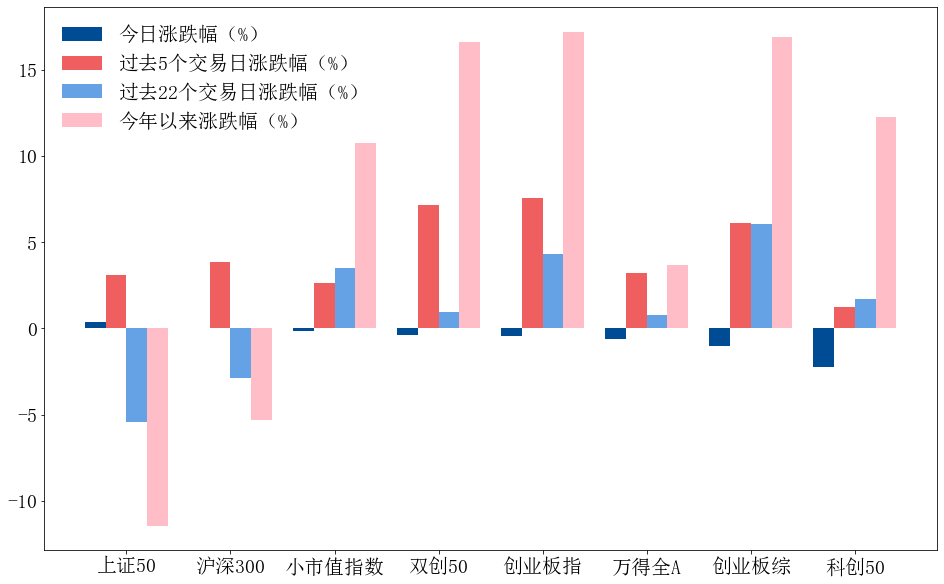

今日是2021-08-03，规模指数收益率如下所示。


,今日涨跌幅（%）,今年以来涨跌幅（%）,过去5个交易日涨跌幅（%）,过去22个交易日涨跌幅（%）
上证50,0.39,-11.45,3.12,-5.41
沪深300,0.01,-5.31,3.85,-2.89
小市值指数,-0.16,10.74,2.65,3.51
双创50,-0.36,16.61,7.16,0.96
创业板指,-0.46,17.23,7.56,4.30
万得全A,-0.62,3.69,3.23,0.81
创业板综,-0.99,16.92,6.11,6.05
科创50,-2.21,12.29,1.22,1.69


In [48]:
# pdf标题
doheading('收益率', h2)

doheading('规模指数', h3)

# 今天和今年
_,tempdf = w.wss("000016.SH,000300.SH,399006.SZ,399102.SZ,881001.WI,8841425.WI,000688.SH,931643.CSI", "pct_chg,pct_chg_per", "tradeDate={};cycle=1;startDate={};endDate={}".format(last_trade_day,str(today.year)+'0101',today), usedf=True)
tempdf.index = ['上证50','沪深300','创业板指','创业板综','万得全A','小市值指数','科创50','双创50']
tempdf.columns = ['今日涨跌幅（%）','今年以来涨跌幅（%）']

# 过去5天
_,tempdf2 = w.wss("000016.SH,000300.SH,399006.SZ,399102.SZ,881001.WI,8841425.WI,000688.SH,931643.CSI", "pct_chg_per", "startDate={};endDate={}".format(last5_trade_day,today), usedf=True)
tempdf2.index = ['上证50','沪深300','创业板指','创业板综','万得全A','小市值指数','科创50','双创50']
tempdf2.columns = ['过去5个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2],axis=1)

# 过去22天
_,tempdf2 = w.wss("000016.SH,000300.SH,399006.SZ,399102.SZ,881001.WI,8841425.WI,000688.SH,931643.CSI", "pct_chg_per", "startDate={};endDate={}".format(last22_trade_day,today), usedf=True)
tempdf2.index = ['上证50','沪深300','创业板指','创业板综','万得全A','小市值指数','科创50','双创50']
tempdf2.columns = ['过去22个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2],axis=1)

text = '今日是{}，规模指数收益率如下所示。'.format(last_trade_day.strftime('%Y-%m-%d'))
tempdf = tempdf.round(2).sort_values(by='今日涨跌幅（%）', ascending=False)

pdf_text(text)
story.append(df_to_table(tempdf))

# 画图
fig,ax = plt.subplots()
xticks = np.arange(len(tempdf.index))
ax.bar(xticks, tempdf['今日涨跌幅（%）'], width=0.2, label='今日涨跌幅（%）', color=barcolor[0])
ax.bar(xticks+0.2, tempdf['过去5个交易日涨跌幅（%）'], width=0.2, label='过去5个交易日涨跌幅（%）',color=barcolor[1])
ax.bar(xticks+0.4, tempdf['过去22个交易日涨跌幅（%）'], width=0.2, label='过去22个交易日涨跌幅（%）', color=barcolor[2])
ax.bar(xticks+0.6, tempdf['今年以来涨跌幅（%）'], width=0.2, label='今年以来涨跌幅（%）', color=barcolor[3])
ax.set_xticks(xticks + 0.3)
ax.set_xticklabels(tempdf.index)
ax.legend(framealpha=0)
plt.show()

fig.savefig('temp20210727_1.png', dpi=400, bbox_inches='tight')
img = Image('temp20210727_1.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

print(text)
tempdf

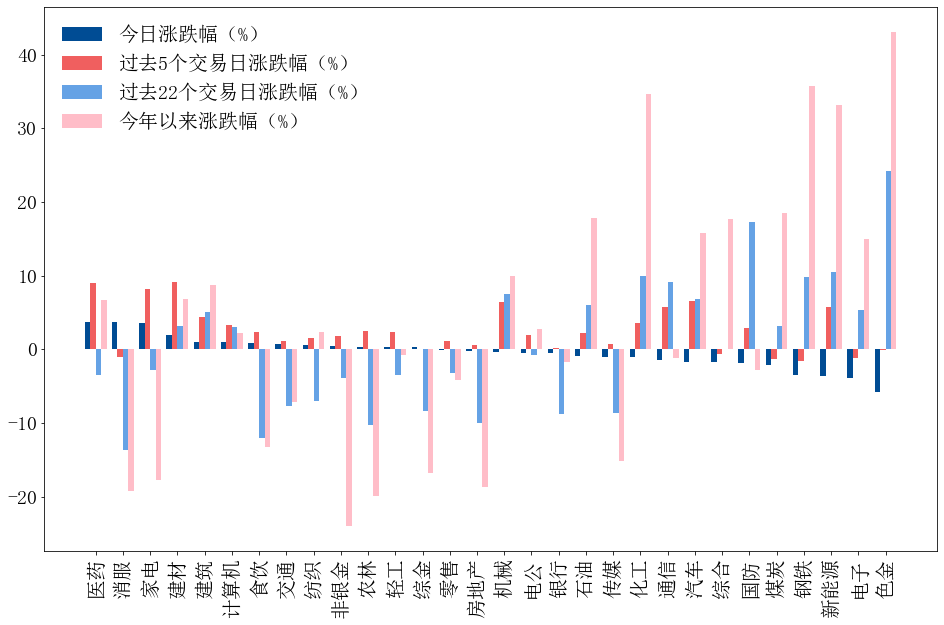

今日是2021-08-03，行业（中信一级行业）收益率如下所示。


,今日涨跌幅（%）,今年以来涨跌幅（%）,过去5个交易日涨跌幅（%）,过去22个交易日涨跌幅（%）
医药,3.73,6.68,9.03,-3.47
消服,3.67,-19.20,-1.10,-13.67
家电,3.54,-17.79,8.16,-2.85
建材,1.89,6.77,9.14,3.17
建筑,1.00,8.69,4.40,5.03
...,...,...,...,...
煤炭,-2.09,18.48,-1.31,3.10
钢铁,-3.47,35.72,-1.56,9.87
新能源,-3.62,33.22,5.76,10.45
电子,-3.94,14.96,-1.13,5.33


In [49]:
doheading('行业指数', h3)

# 今天和今年
_,tempdf = w.wss("CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,"
                  +"CI005011.WI,CI005012.WI,CI005013.WI,CI005014.WI,CI005015.WI,CI005016.WI,CI005017.WI,CI005018.WI,CI005019.WI,CI005020.WI,"
                  +"CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI,CI005030.WI,",
                 "pct_chg,pct_chg_per", "tradeDate={};cycle=1;startDate={};endDate={}".format(last_trade_day,str(today.year)+'0101',today), usedf=True)
tempdf.index = ['石油','煤炭','色金','电公','钢铁','化工','建筑','建材','轻工','机械','新能源','国防','汽车','零售','消服','家电',
                   '纺织','医药','食饮','农林','银行','非银金','房地产','交通','电子','通信','计算机','传媒','综合','综金']
tempdf.columns = ['今日涨跌幅（%）','今年以来涨跌幅（%）']

# 过去5天
_,tempdf2 = w.wss("CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,"
                  +"CI005011.WI,CI005012.WI,CI005013.WI,CI005014.WI,CI005015.WI,CI005016.WI,CI005017.WI,CI005018.WI,CI005019.WI,CI005020.WI,"
                  +"CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI,CI005030.WI,",
                 "pct_chg_per", "startDate={};endDate={}".format(last5_trade_day,today), usedf=True)
tempdf2.index = ['石油','煤炭','色金','电公','钢铁','化工','建筑','建材','轻工','机械','新能源','国防','汽车','零售','消服','家电',
                   '纺织','医药','食饮','农林','银行','非银金','房地产','交通','电子','通信','计算机','传媒','综合','综金']
tempdf2.columns = ['过去5个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2],axis=1)

# 过去22天
_,tempdf2 = w.wss("CI005001.WI,CI005002.WI,CI005003.WI,CI005004.WI,CI005005.WI,CI005006.WI,CI005007.WI,CI005008.WI,CI005009.WI,CI005010.WI,"
                  +"CI005011.WI,CI005012.WI,CI005013.WI,CI005014.WI,CI005015.WI,CI005016.WI,CI005017.WI,CI005018.WI,CI005019.WI,CI005020.WI,"
                  +"CI005021.WI,CI005022.WI,CI005023.WI,CI005024.WI,CI005025.WI,CI005026.WI,CI005027.WI,CI005028.WI,CI005029.WI,CI005030.WI,",
                 "pct_chg_per", "startDate={};endDate={}".format(last22_trade_day,today), usedf=True)
tempdf2.index = ['石油','煤炭','色金','电公','钢铁','化工','建筑','建材','轻工','机械','新能源','国防','汽车','零售','消服','家电',
                   '纺织','医药','食饮','农林','银行','非银金','房地产','交通','电子','通信','计算机','传媒','综合','综金']
tempdf2.columns = ['过去22个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2],axis=1)

text = '今日是{}，行业（中信一级行业）收益率如下所示。'.format(last_trade_day.strftime('%Y-%m-%d'))
tempdf = tempdf.round(2).sort_values(by='今日涨跌幅（%）', ascending=False)

pdf_text(text)
story.append(df_to_table(tempdf))

# 画图
fig,ax = plt.subplots()
xticks = np.arange(len(tempdf.index))
ax.bar(xticks, tempdf['今日涨跌幅（%）'], width=0.2, label='今日涨跌幅（%）', color=barcolor[0])
ax.bar(xticks+0.2, tempdf['过去5个交易日涨跌幅（%）'], width=0.2, label='过去5个交易日涨跌幅（%）',color=barcolor[1])
ax.bar(xticks+0.4, tempdf['过去22个交易日涨跌幅（%）'], width=0.2, label='过去22个交易日涨跌幅（%）', color=barcolor[2])
ax.bar(xticks+0.6, tempdf['今年以来涨跌幅（%）'], width=0.2, label='今年以来涨跌幅（%）', color=barcolor[3])
ax.set_xticks(xticks + 0.3)
ax.set_xticklabels(tempdf.index, rotation=90)
ax.legend(framealpha=0)
plt.show()

fig.savefig('temp20210727_2.png', dpi=400, bbox_inches='tight')
img = Image('temp20210727_2.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

print(text)
tempdf

  2%|█▋                                                                                | 2/100 [00:00<00:26,  3.67it/s]

目前板块指z数已经更新到884998.WI


今日是2021-08-03，当日概念收益率前30和后30如下表所示（画图的时候已剔除连板指数、触板指数）。
          今日涨跌幅（%）  今年以来涨跌幅（%）  过去5个交易日涨跌幅（%）  过去22个交易日涨跌幅（%）
概念名称                                                         
肝素钠指数        10.89       21.95          19.07           15.51
新冠肺炎检测指数      6.50       24.18          18.00            4.48
疫苗指数          5.68       18.39          13.28            4.91
CRO指数         5.20       57.40          10.53            2.91
体外诊断指数        5.09        7.58          13.23            0.04
...            ...         ...            ...             ...
港珠澳大桥指数       3.12       11.62           6.58            5.57
在线旅游指数        3.11       -6.26          -2.34           -5.40
辅助生殖指数        3.11       11.39           9.22            0.92
密码学指数         3.06        8.41           3.07           12.88
仿制药指数         2.92       -1.20           5.37           -7.67

[30 rows x 4 columns]


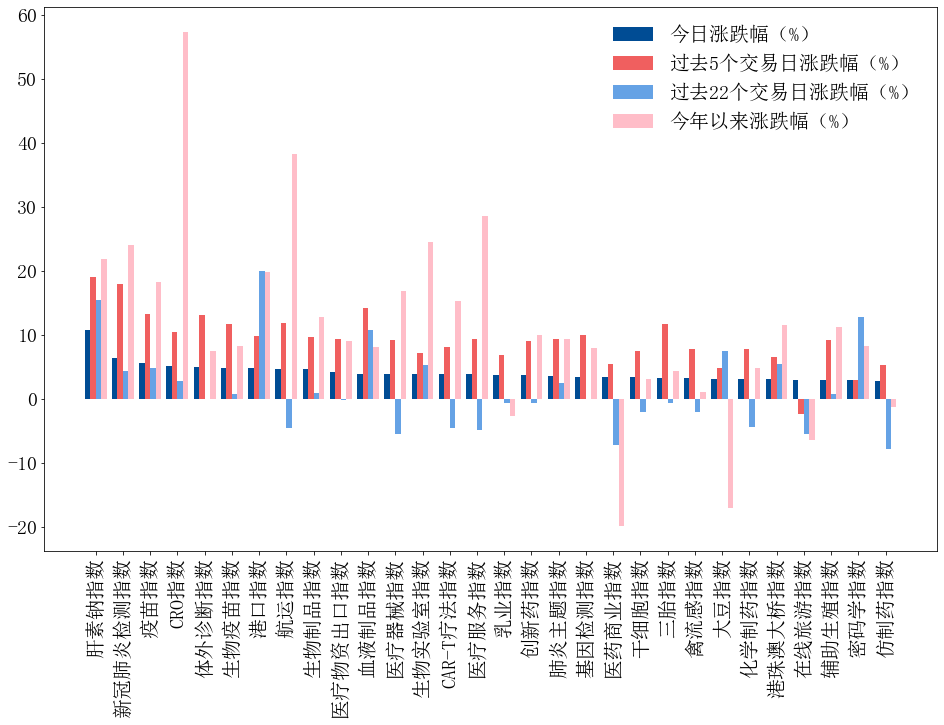

           今日涨跌幅（%）  今年以来涨跌幅（%）  过去5个交易日涨跌幅（%）  过去22个交易日涨跌幅（%）
概念名称                                                          
小金属指数         -5.02       53.90           0.24           27.68
稀土永磁指数        -5.05       43.28           3.08           24.45
芯片指数          -5.09       33.69          -1.34           13.46
钨矿指数          -5.22       47.00          -2.58           22.07
钠离子电池指数       -5.46       51.84           1.00           23.24
...             ...         ...            ...             ...
靶材指数          -7.72       34.74           1.52           21.66
中芯国际产业链指数     -8.24       43.06          -1.43           20.82
盐湖提锂指数        -8.92      121.03           6.48           36.70
长江存储指数        -9.11       60.39          -0.56           29.37
半导体设备指数       -9.27       58.96          -2.80           26.56

[30 rows x 4 columns]


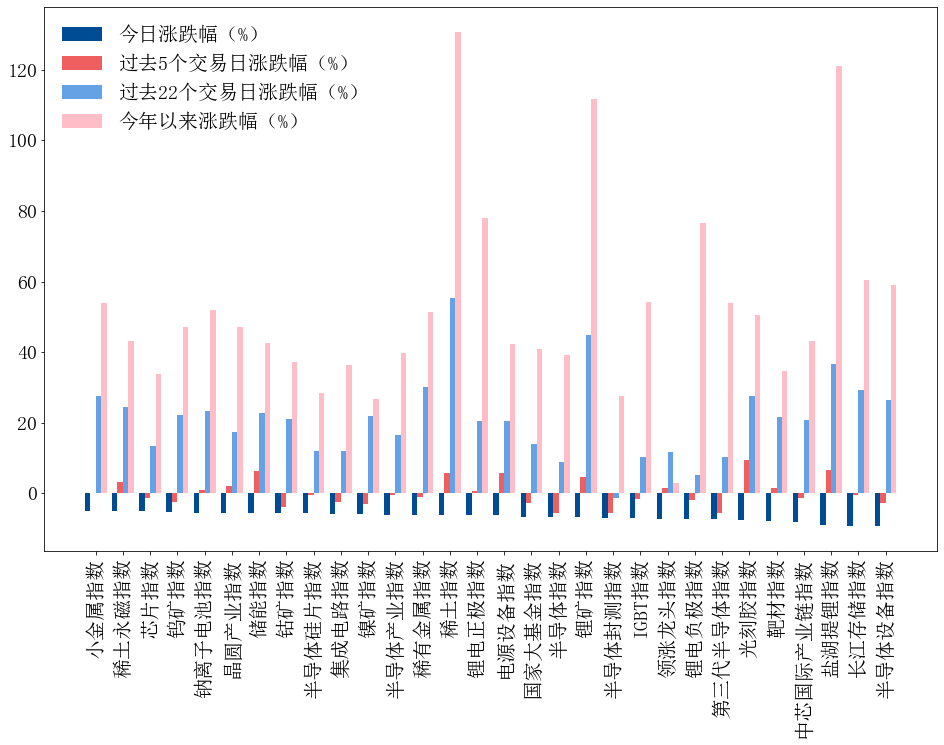

In [50]:
# pdf
doheading('概念指数', h3)

# 扩展概念指数的编号，扩展100位往后，因为概念指数可能后续会有新增，只要编号未超过885998都ok
code_list = "884001.WI,884025.WI,884028.WI,884030.WI,884031.WI,884032.WI,884034.WI,884035.WI,884036.WI,884037.WI,884039.WI,884040.WI,884041.WI,884045.WI,884046.WI,884048.WI,884050.WI,884052.WI,884053.WI,884057.WI,884059.WI,884061.WI,884062.WI,884068.WI,884069.WI,884074.WI,884075.WI,884076.WI,884077.WI,884079.WI,884080.WI,884081.WI,884086.WI,884087.WI,884088.WI,884089.WI,884090.WI,884091.WI,884092.WI,884093.WI,884095.WI,884096.WI,884098.WI,884099.WI,884100.WI,8841000.WI,8841002.WI,8841004.WI,8841005.WI,8841007.WI,884101.WI,8841011.WI,8841013.WI,8841014.WI,8841016.WI,8841017.WI,8841018.WI,8841019.WI,884102.WI,8841020.WI,8841021.WI,8841024.WI,8841026.WI,8841027.WI,8841028.WI,884103.WI,8841032.WI,8841034.WI,8841035.WI,8841038.WI,8841039.WI,884104.WI,8841040.WI,8841041.WI,8841042.WI,8841043.WI,8841044.WI,8841045.WI,8841046.WI,8841047.WI,8841048.WI,8841049.WI,8841050.WI,8841051.WI,8841052.WI,8841054.WI,8841055.WI,8841056.WI,8841058.WI,884106.WI,8841062.WI,8841063.WI,8841064.WI,8841066.WI,8841067.WI,8841068.WI,8841069.WI,884107.WI,8841070.WI,8841071.WI,8841072.WI,8841074.WI,8841076.WI,8841079.WI,8841080.WI,8841081.WI,8841082.WI,8841083.WI,8841085.WI,8841086.WI,8841087.WI,8841089.WI,884109.WI,8841090.WI,8841091.WI,8841092.WI,8841093.WI,8841095.WI,8841096.WI,8841098.WI,8841099.WI,884110.WI,8841100.WI,8841101.WI,8841103.WI,8841104.WI,8841105.WI,8841106.WI,8841107.WI,8841108.WI,8841109.WI,884111.WI,8841112.WI,8841114.WI,8841118.WI,884112.WI,8841124.WI,8841125.WI,8841126.WI,8841129.WI,884113.WI,8841130.WI,8841132.WI,8841133.WI,8841134.WI,8841135.WI,8841136.WI,8841137.WI,8841138.WI,8841139.WI,884114.WI,8841141.WI,8841144.WI,8841145.WI,8841147.WI,8841149.WI,884115.WI,8841150.WI,8841152.WI,8841153.WI,8841156.WI,8841158.WI,8841159.WI,884116.WI,8841161.WI,8841163.WI,8841164.WI,8841165.WI,8841167.WI,8841169.WI,8841170.WI,8841171.WI,8841173.WI,8841174.WI,8841175.WI,8841176.WI,8841177.WI,8841178.WI,8841179.WI,884118.WI,8841180.WI,8841182.WI,8841183.WI,8841184.WI,8841185.WI,8841187.WI,8841189.WI,884119.WI,8841191.WI,8841192.WI,8841193.WI,8841194.WI,8841195.WI,8841196.WI,8841201.WI,8841202.WI,8841205.WI,8841206.WI,8841207.WI,8841208.WI,8841209.WI,884121.WI,8841210.WI,8841211.WI,8841212.WI,8841213.WI,8841214.WI,8841215.WI,8841216.WI,8841217.WI,8841218.WI,8841219.WI,884122.WI,8841220.WI,8841221.WI,8841222.WI,8841223.WI,8841224.WI,8841225.WI,8841226.WI,8841227.WI,8841228.WI,884123.WI,8841230.WI,8841231.WI,8841232.WI,8841233.WI,8841234.WI,8841235.WI,8841237.WI,8841238.WI,884124.WI,8841240.WI,8841241.WI,8841242.WI,8841243.WI,8841244.WI,8841245.WI,8841246.WI,8841247.WI,8841248.WI,8841249.WI,884125.WI,8841250.WI,8841251.WI,8841252.WI,8841253.WI,8841254.WI,8841255.WI,8841256.WI,8841257.WI,8841258.WI,8841259.WI,884126.WI,8841260.WI,8841261.WI,8841262.WI,8841263.WI,8841264.WI,8841265.WI,8841266.WI,8841267.WI,8841268.WI,8841269.WI,884127.WI,8841271.WI,8841272.WI,8841273.WI,8841277.WI,8841278.WI,8841279.WI,884128.WI,8841280.WI,8841281.WI,8841282.WI,8841283.WI,8841284.WI,8841285.WI,8841286.WI,8841287.WI,8841288.WI,8841289.WI,884129.WI,8841290.WI,8841291.WI,8841292.WI,8841293.WI,8841294.WI,8841295.WI,8841296.WI,8841297.WI,8841298.WI,8841299.WI,884130.WI,8841300.WI,8841301.WI,8841302.WI,8841303.WI,8841304.WI,8841305.WI,8841306.WI,8841307.WI,8841308.WI,8841309.WI,884131.WI,8841310.WI,8841311.WI,8841312.WI,8841313.WI,8841314.WI,8841315.WI,8841316.WI,8841317.WI,8841318.WI,8841319.WI,884132.WI,8841320.WI,8841321.WI,8841322.WI,8841323.WI,8841324.WI,8841325.WI,8841326.WI,8841327.WI,8841328.WI,884133.WI,8841330.WI,8841331.WI,8841332.WI,8841334.WI,8841335.WI,8841336.WI,8841337.WI,8841338.WI,8841339.WI,884134.WI,8841340.WI,8841341.WI,8841342.WI,8841343.WI,8841344.WI,8841345.WI,8841346.WI,8841347.WI,8841348.WI,8841349.WI,884135.WI,8841350.WI,8841351.WI,8841352.WI,8841353.WI,8841354.WI,8841355.WI,8841356.WI,8841357.WI,8841358.WI,8841359.WI,884136.WI,8841360.WI,8841361.WI,8841362.WI,8841363.WI,8841364.WI,8841365.WI,8841366.WI,8841367.WI,8841368.WI,8841369.WI,884137.WI,8841370.WI,8841371.WI,8841372.WI,8841373.WI,8841374.WI,8841375.WI,8841376.WI,8841377.WI,8841378.WI,8841379.WI,884138.WI,8841380.WI,8841381.WI,8841382.WI,8841383.WI,8841384.WI,8841385.WI,8841386.WI,8841387.WI,8841388.WI,8841389.WI,884139.WI,8841390.WI,8841391.WI,8841392.WI,8841393.WI,8841394.WI,8841395.WI,8841396.WI,8841397.WI,8841398.WI,8841399.WI,884140.WI,8841400.WI,8841401.WI,8841402.WI,8841403.WI,8841404.WI,8841405.WI,8841406.WI,8841407.WI,8841408.WI,8841409.WI,884141.WI,8841410.WI,8841411.WI,8841412.WI,8841413.WI,8841414.WI,8841415.WI,8841416.WI,8841417.WI,8841418.WI,8841419.WI,884142.WI,8841420.WI,8841421.WI,8841422.WI,8841423.WI,8841424.WI,8841425.WI,8841426.WI,8841427.WI,8841428.WI,8841429.WI,884143.WI,8841430.WI,8841431.WI,8841432.WI,8841433.WI,8841434.WI,8841435.WI,8841436.WI,8841437.WI,8841438.WI,8841439.WI,884144.WI,8841440.WI,8841441.WI,8841442.WI,8841443.WI,8841444.WI,8841445.WI,8841446.WI,884145.WI,884146.WI,884148.WI,884149.WI,884151.WI,884152.WI,884153.WI,884154.WI,884155.WI,884156.WI,884157.WI,884158.WI,884159.WI,884160.WI,884161.WI,884162.WI,884163.WI,884164.WI,884165.WI,884166.WI,884167.WI,884168.WI,884169.WI,884170.WI,884171.WI,884172.WI,884173.WI,884174.WI,884175.WI,884176.WI,884177.WI,884178.WI,884179.WI,884180.WI,884181.WI,884182.WI,884183.WI,884184.WI,884185.WI,884186.WI,884187.WI,884188.WI,884189.WI,884190.WI,884191.WI,884192.WI,884193.WI,884194.WI,884195.WI,884196.WI,884197.WI,884198.WI,884199.WI,884200.WI,884201.WI,884202.WI,884203.WI,884204.WI,884205.WI,884206.WI,884207.WI,884208.WI,884209.WI,884210.WI,884211.WI,884212.WI,884213.WI,884214.WI,884215.WI,884216.WI,884217.WI,884218.WI,884219.WI,884220.WI,884221.WI,884222.WI,884224.WI,884225.WI,884226.WI,884227.WI,884228.WI,884229.WI,884230.WI,884231.WI,884232.WI,884233.WI,884234.WI,884235.WI,884236.WI,884237.WI,884238.WI,884239.WI,884240.WI,884241.WI,884242.WI,884243.WI,884244.WI,884245.WI,884246.WI,884247.WI,884248.WI,884249.WI,884250.WI,884251.WI,884252.WI,884253.WI,884254.WI,884255.WI,884256.WI,884257.WI,884258.WI,884662.WI,884665.WI,884681.WI,884685.WI,884694.WI,884698.WI,884701.WI,884702.WI,884705.WI,884714.WI,884715.WI,884739.WI,884745.WI,884766.WI,884767.WI,884774.WI,884775.WI,884777.WI,884782.WI,884785.WI,884786.WI,884789.WI,884790.WI,884793.WI,884794.WI,884795.WI,884800.WI,884801.WI,884811.WI,884813.WI,884814.WI,884816.WI,884817.WI,884818.WI,884834.WI,884841.WI,884845.WI,884857.WI,884858.WI,884869.WI,884870.WI,884871.WI,884874.WI,884876.WI,884878.WI,884880.WI,884882.WI,884887.WI,884894.WI,884895.WI,884898.WI,884909.WI,884927.WI,884934.WI,884944.WI,884953.WI,884963.WI,884965.WI,884966.WI,884969.WI,884979.WI,884987.WI,884992.WI,884995.WI,884996.WI"
for i in tqdm(range(100)):
    num = 884997 + i 
    temp = str(num) + '.WI'
    _,tempdf2 = w.wss(temp, "sec_name,pct_chg,pct_chg_per", "tradeDate={};cycle=1;startDate={};endDate={}".format(last_trade_day,str(today.year)+'0101',today), usedf=True)
    tempdf2.columns = ['概念名称','今日涨跌幅（%）','今年以来涨跌幅（%）']
    if tempdf2.iloc[0,0] == None: # 还没有这个版块
        print('目前板块指z数已经更新到' + str(num-1) + '.WI')
        break
    else:
        code_list = code_list + ',' + temp

# 今日和今年
_,tempdf = w.wss(code_list, "sec_name,pct_chg,pct_chg_per", "tradeDate={};cycle=1;startDate={};endDate={}".format(last_trade_day,str(today.year)+'0101',today), usedf=True)
tempdf.columns = ['概念名称','今日涨跌幅（%）','今年以来涨跌幅（%）']

# 过去5天
_,tempdf2 = w.wss(code_list, "sec_name,pct_chg_per", "startDate={};endDate={}".format(last5_trade_day,today), usedf=True)
tempdf2.columns = ['概念名称','过去5个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2.iloc[:,1:]],axis=1)

# 过去22天
_,tempdf2 = w.wss(code_list, "sec_name,pct_chg_per", "startDate={};endDate={}".format(last22_trade_day,today), usedf=True)
tempdf2.columns = ['概念名称','过去22个交易日涨跌幅（%）']
tempdf = pd.concat([tempdf,tempdf2.iloc[:,1:]],axis=1)    

# pdf
text = '今日是{}，当日概念收益率前30和后30如下表所示（画图的时候已剔除连板指数、触板指数）。'.format(last_trade_day.strftime('%Y-%m-%d'))
print(text)
tempdf = tempdf.round(2).sort_values(by='今日涨跌幅（%）', ascending=False)
tempdf.set_index('概念名称', inplace=True)

# 当日收益前30画图
tempdf2 = tempdf.iloc[0:30,:]
story.append(df_to_table(tempdf2))
print(tempdf2)
try:
    tempdf2.drop('连板指数',inplace=True)
except:
    pass
fig,ax = plt.subplots()
xticks = np.arange(len(tempdf2.index))
ax.bar(xticks, tempdf2['今日涨跌幅（%）'], width=0.2, label='今日涨跌幅（%）', color=barcolor[0])
ax.bar(xticks+0.2, tempdf2['过去5个交易日涨跌幅（%）'], width=0.2, label='过去5个交易日涨跌幅（%）',color=barcolor[1])
ax.bar(xticks+0.4, tempdf2['过去22个交易日涨跌幅（%）'], width=0.2, label='过去22个交易日涨跌幅（%）', color=barcolor[2])
ax.bar(xticks+0.6, tempdf2['今年以来涨跌幅（%）'], width=0.2, label='今年以来涨跌幅（%）', color=barcolor[3])
ax.set_xticks(xticks + 0.3)
ax.set_xticklabels(tempdf2.index, rotation=90)
ax.legend(framealpha=0)
plt.show()

fig.savefig('temp20210727_3.png', dpi=400, bbox_inches='tight')
img = Image('temp20210727_3.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)

# 当日收益后30画图
tempdf2 = tempdf.iloc[-30:,:]
print(tempdf2)
story.append(df_to_table(tempdf2))
try:
    tempdf2.drop('触板指数',inplace=True)
except:
    pass
fig,ax = plt.subplots()
xticks = np.arange(len(tempdf2.index))
ax.bar(xticks, tempdf2['今日涨跌幅（%）'], width=0.2, label='今日涨跌幅（%）', color=barcolor[0])
ax.bar(xticks+0.2, tempdf2['过去5个交易日涨跌幅（%）'], width=0.2, label='过去5个交易日涨跌幅（%）',color=barcolor[1])
ax.bar(xticks+0.4, tempdf2['过去22个交易日涨跌幅（%）'], width=0.2, label='过去22个交易日涨跌幅（%）', color=barcolor[2])
ax.bar(xticks+0.6, tempdf2['今年以来涨跌幅（%）'], width=0.2, label='今年以来涨跌幅（%）', color=barcolor[3])
ax.set_xticks(xticks + 0.3)
ax.set_xticklabels(tempdf2.index, rotation=90)
ax.legend(framealpha=0)
plt.show()

fig.savefig('temp20210727_4.png', dpi=400, bbox_inches='tight')
img = Image('temp20210727_4.png')
img.drawHeight = figheight
img.drawWidth = figwidth
story.append(img)


# 生成PDF

参数定义

In [51]:
doc.multiBuild(story)

3

新能源产业链研究框架

宁德、隆基

量的超预期爆发是光伏板块的源动力。对需求的研究。需求一直在增长，

行业有催化剂，

